# Классификация заемщиков линейными моделями, part 2

## курс "Машинное обучение 1", программа AIMasters, 2024

## Студент: Дашиев Батор Жаргалович

Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). 

Описание колонок находится в файле `description.csv`.

Для начала мы за вас считаем данные и поделим на обучение и тест.

Код в чтение, разбиение менять не нужно.

Выполняя задания, не забывайте про [устав](https://t.me/c/2206639786/270/271).

In [1]:
# не меняем код
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150


data = pd.read_csv('application_train.csv')
data.columns = ['sk_id_curr', 'target'] + list(data.columns[2:])
data.head(3)

sk_id_curr  target NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   
2                       0                        0              Government   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   
2                          NaN              NaN             NaN   

   ELEVATORS_AVG  ...  APARTMENTS_MEDI  BASEMENTAREA_MEDI  \
0           0.00  ...   

In [2]:
# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


## Пайплайны (5 баллов)

Вам предлагается реализовать свой пайплайн предобработки данных + обучение линейной модели.

Примеры использования sklearn [pipeline](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html) можете найти в ноутбуке с семинара по предобработке.

Можно использовать все, что есть в https://scikit-learn.org/1.5/modules/preprocessing.html + оборачивать все в кастомные трансформеры (про них ниже).

На выходе у вас должна стоять линейная модель.

Любой код ниже **можно** менять.

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

In [4]:
num_features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns
num_features

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=104)

In [5]:
cat_features = data.select_dtypes('object').columns
cat_features, len(cat_features)

(Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
       dtype='object'),
 16)

In [6]:
num_transformer = Pipeline([
    ('imp_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])
cat_transformer = Pipeline(steps=[
    ('imp_most_freq', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [7]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    transformers=[
        ('num', num_transformer, list(num_features)),
        ('cat', cat_transformer, list(cat_features)),
    ]
)

In [8]:
pipeline = Pipeline([
    ('ct', ct),
    ('model',  LogisticRegression(random_state=0, n_jobs=-1, max_iter=2000)),
])

In [9]:
pipeline.fit(data_dict['tr'], data_dict['tr'].target)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE', 'FLAG_MOBIL',
                                                   'FLAG_EMP_P...
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('model',
                 LogisticRegression(max_iter=2000, n_jobs=-1, random_state=0))])

In [10]:
from sklearn.metrics import roc_auc_score

roc_auc_score(data_dict['tst'].target, pipeline.predict_proba(data_dict['tst'])[:, 1])

0.7475056235327491

### Кастомные трансформеры

В этом пункте вам нужно добавить один любой кастомный трансформер данных. (можно больше, минимум 1)

Примеры кастомных трансформеров можно найти
- в семинаре по предобработке
- https://www.andrewvillazon.com/custom-scikit-learn-transformers/
- https://medium.com/@pgshanding/creating-custom-transformers-in-python-and-scikit-learn-10767487017e
- в интернете :)

Варианты трансформеров
- генерация новых признаков, примеры новых признаков можно найти в соревновании с kaggle, откуда был взят датасет https://www.kaggle.com/competitions/home-credit-default-risk/code?competitionId=9120&sortBy=voteCount&excludeNonAccessedDatasources=true, т.е. ваш трансформер принимает на вход pd.DataFrame и добавляет новые колонки с признаками
- категорийные энкодеры, которые не реализованы в sklearn, можно взять готовые реализации и обернуть их в свой трансформер. Примеры категорийных энкодеров - https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark, примеры реализаций - https://contrib.scikit-learn.org/category_encoders/ (если не требуется дополнительный код для использования в вашем пайплайне, можете использовать as is)
- замена пропусков от SimpleImputer с добавлением нового признака, что был пропуск 
- эмбединг текста из одного/нескольких признаков
- любой другой ваш вариант, который дает результат

Не забудьте добавить комментарий, что делает ваш трансформер.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer
from category_encoders.sum_coding import SumEncoder
import sys
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
sys.path.append(r"C:\Users\bator\Desktop\L4m\Учеба\aim\ML1")

import my_utils

Воспользуемся ниже реализованными на прошлом семинаре функциями. Предъявим информацию о колонках датафрейма (с самым большим количеством уникальных значений). Также предъявим графики зависимости от таргета.

In [12]:
data_train_info = my_utils.get_df_info(data_dict["tr"])
data_train_info.sort_values(by="nunique", ascending=False).head(20)

dtype nunique  example1   example2      zero  \
sk_id_curr                int64  215290    100002     100003        -1   
EXT_SOURCE_2            float64  102099  0.262949   0.622246        -1   
EXT_SOURCE_1            float64   84075  0.083037   0.311267        -1   
DAYS_BIRTH                int64   17392     -9461     -16765        -1   
DAYS_REGISTRATION       float64   15220   -3648.0    -1186.0    z: 0.0   
AMT_ANNUITY             float64   12820   24700.5    35698.5        -1   
DAYS_EMPLOYED             int64   11716      -637      -1188    z: 0.0   
DAYS_ID_PUBLISH           int64    6126     -2120       -291    z: 0.0   
LIVINGAREA_MODE         float64    5085    0.0198     0.0554  z: 0.001   
AMT_CREDIT              float64    5081  406597.5  1293502.5        -1   
LIVINGAREA_MEDI         float64    5073    0.0193     0.0558  z: 0.001   
LIVINGAREA_AVG          float64    4993     0.019     0.0549  z: 0.001   
TOTALAREA_MODE          float64    4907    0.0149     0.0714  z: 0.002   
DAYS_LAST_PHONE_CHANGE  float64    3711   -1134.0     -828.0  z: 0.122   
BASEMENTAREA_MODE       float64    3696    0.0383     0.0538  z: 0.054   
BASEMENTAREA_AVG        float64    3632    0.0369     0.0529  z: 0.048   
BASEMENTAREA_MEDI       float64    3627    0.0369     0.0529  z: 0.048   
LANDAREA_MEDI           float64    3394    0.0375     0.0132  z: 0.052   
LANDAREA_MODE           float64    3393    0.0377     0.0128  z: 0.057   
LANDAREA_AVG            float64    3363    0.0369      0.013  z: 0.051   

                             nan empty_str    vc_max vc_max_prop trash_score  
sk_id_curr                    -1        -1    100002         0.0          -1  
EXT_SOURCE_2            n: 0.002        -1  0.285898       0.002       0.002  
EXT_SOURCE_1            n: 0.563        -1  0.285593         0.0       0.563  
DAYS_BIRTH                    -1        -1  -13749.0         0.0          -1  
DAYS_REGISTRATION             -1        -1      -1.0         0.0         0.0  
AMT_ANNUITY               n: 0.0        -1    9000.0       0.021         0.0  
DAYS_EMPLOYED                 -1        -1  365243.0        0.18         0.0  
DAYS_ID_PUBLISH               -1        -1   -4256.0       0.001         0.0  
LIVINGAREA_MODE         n: 0.503        -1       0.0       0.001       0.504  
AMT_CREDIT                    -1        -1  450000.0       0.031          -1  
LIVINGAREA_MEDI         n: 0.503        -1       0.0       0.001       0.504  
LIVINGAREA_AVG          n: 0.503        -1       0.0       0.001       0.504  
TOTALAREA_MODE          n: 0.483        -1       0.0       0.002       0.485  
DAYS_LAST_PHONE_CHANGE    n: 0.0        -1       0.0       0.122       0.122  
BASEMENTAREA_MODE       n: 0.586        -1       0.0       0.054       0.639  
BASEMENTAREA_AVG        n: 0.586        -1       0.0       0.048       0.634  
BASEMENTAREA_MEDI       n: 0.586        -1       0.0       0.048       0.634  
LANDAREA_MEDI           n: 0.594        -1       0.0       0.052       0.646  
LANDAREA_MODE           n: 0.594        -1       0.0       0.057       0.651  
LANDAREA_AVG            n: 0.594        -1       0.0       0.051       0.645

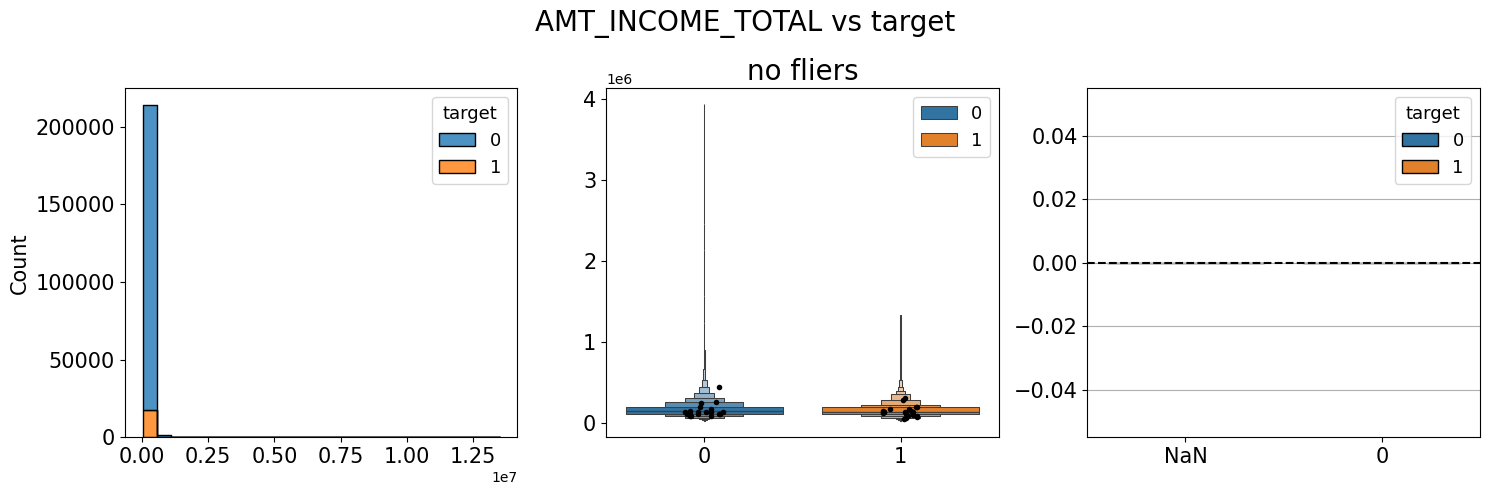

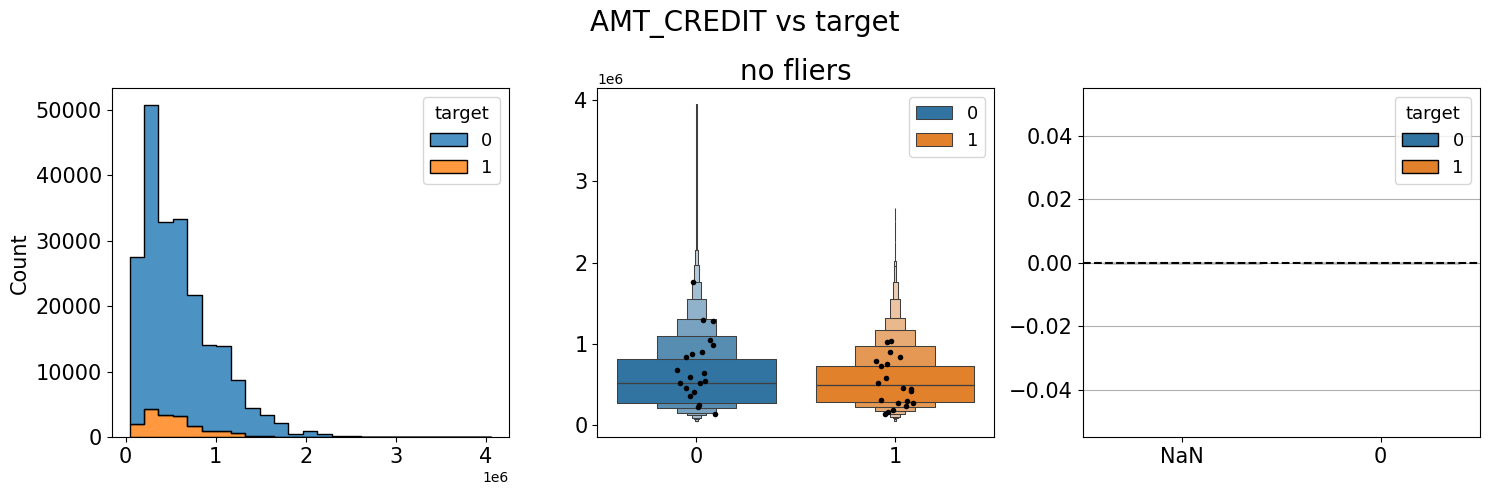

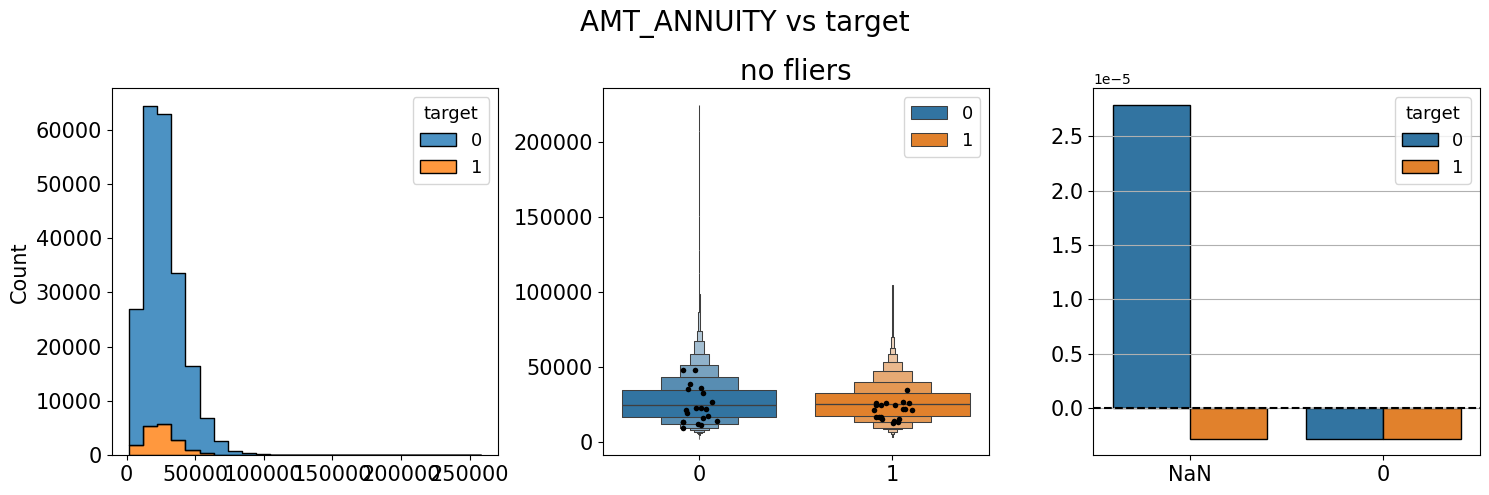

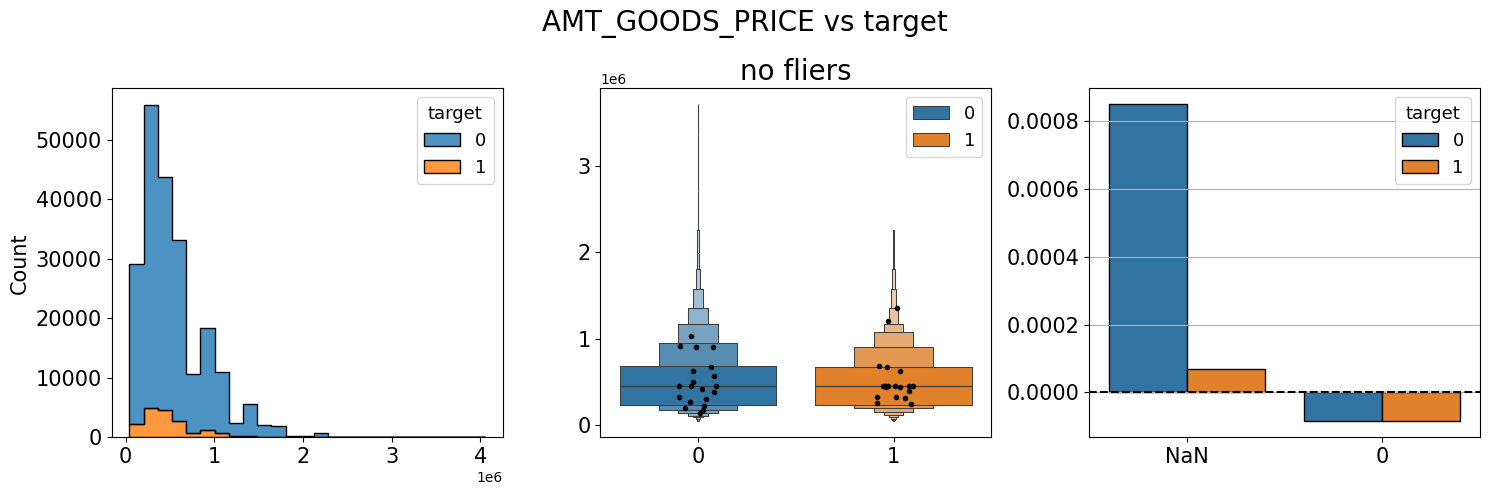

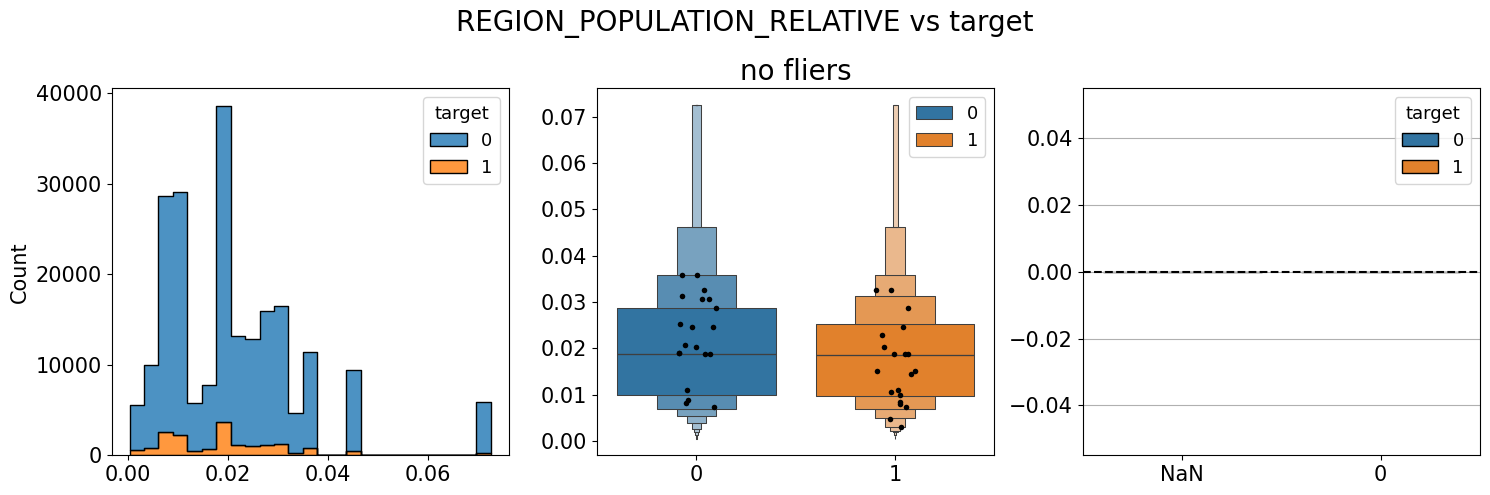

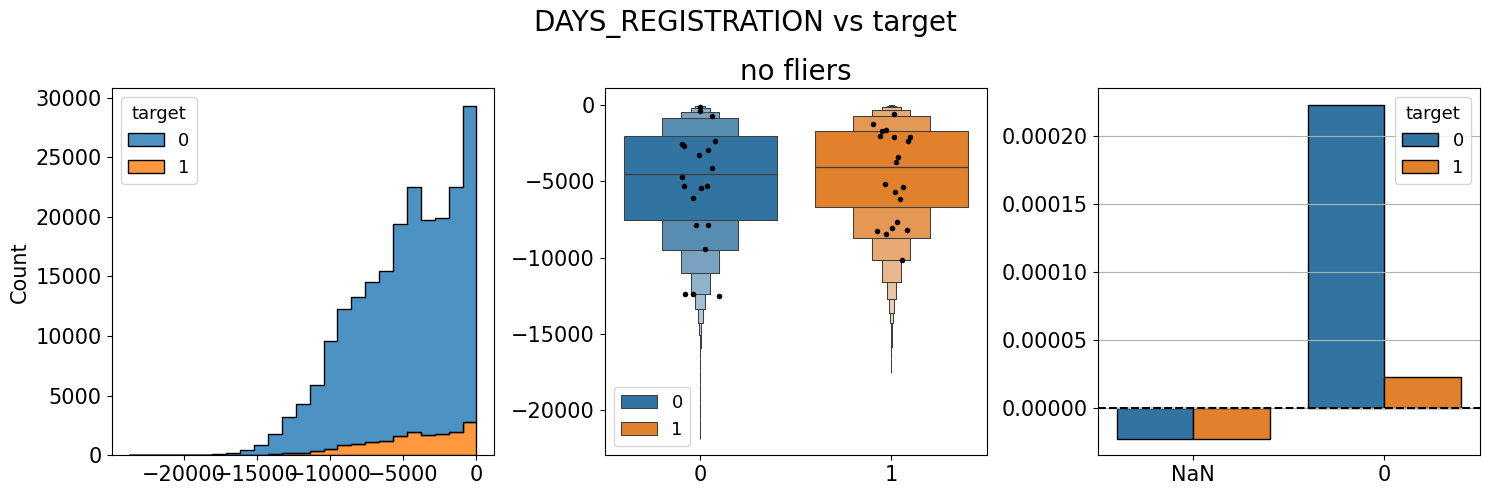

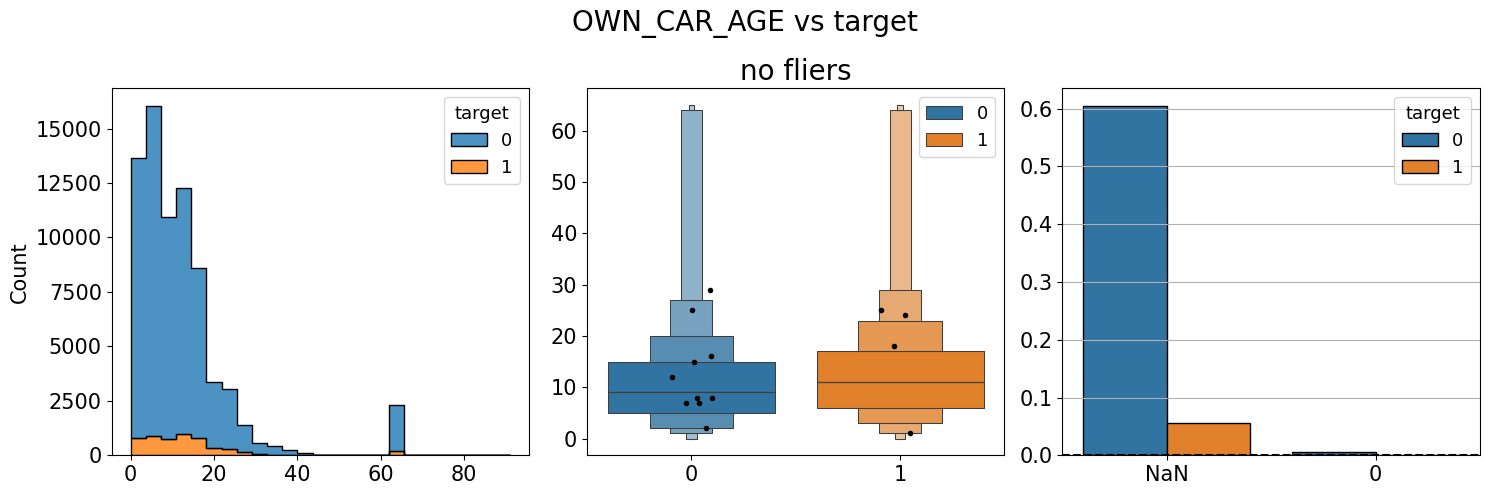

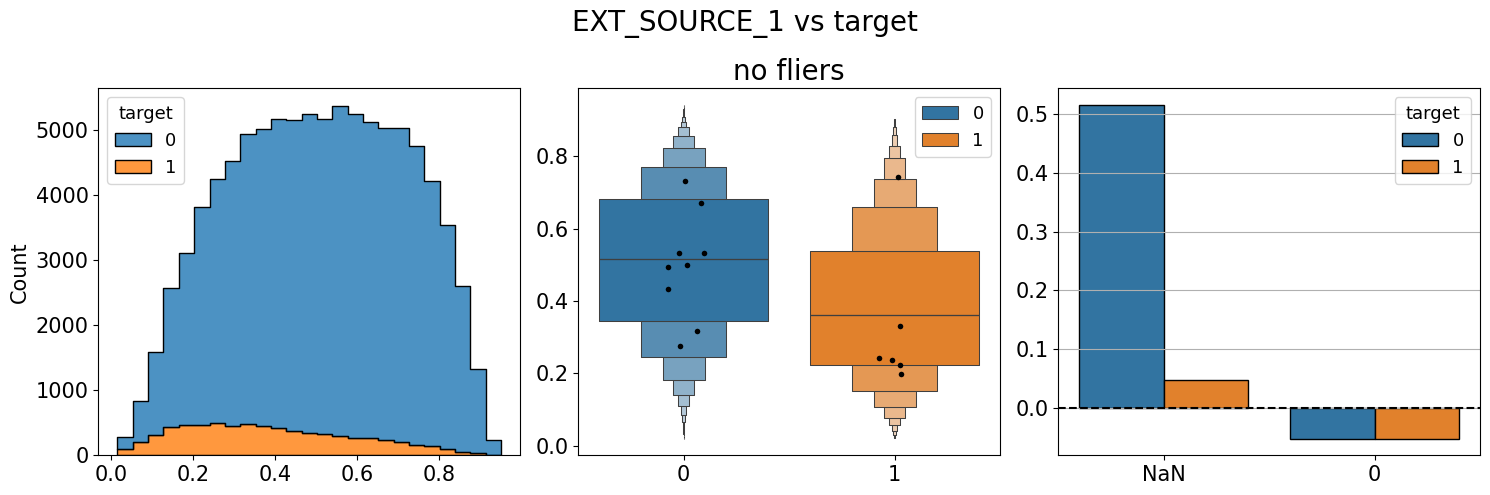

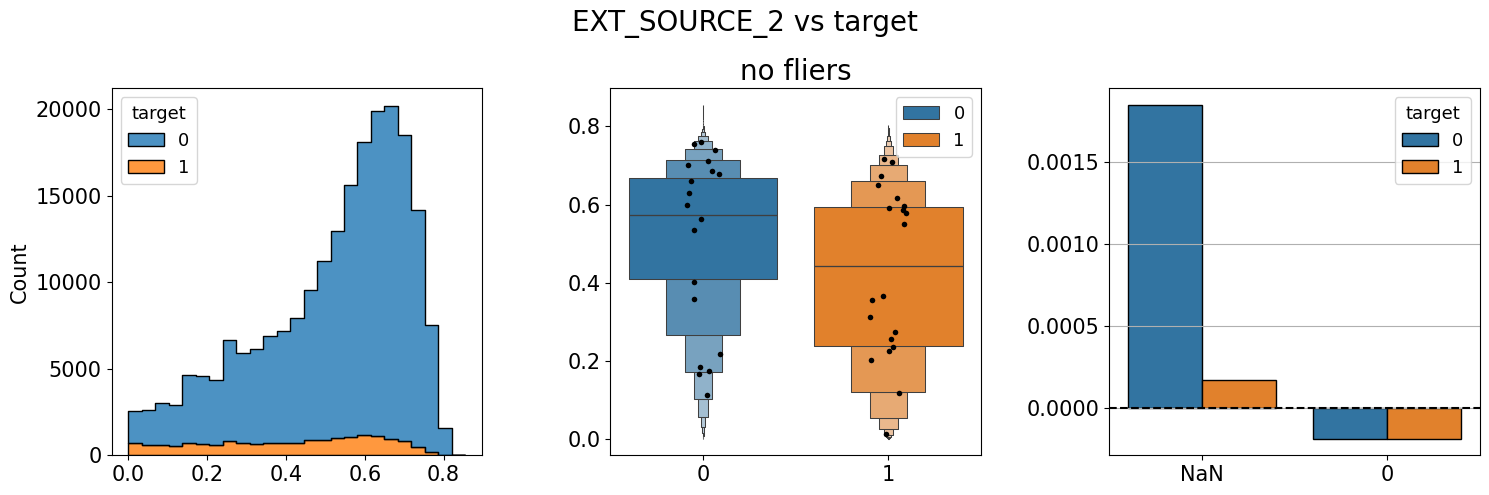

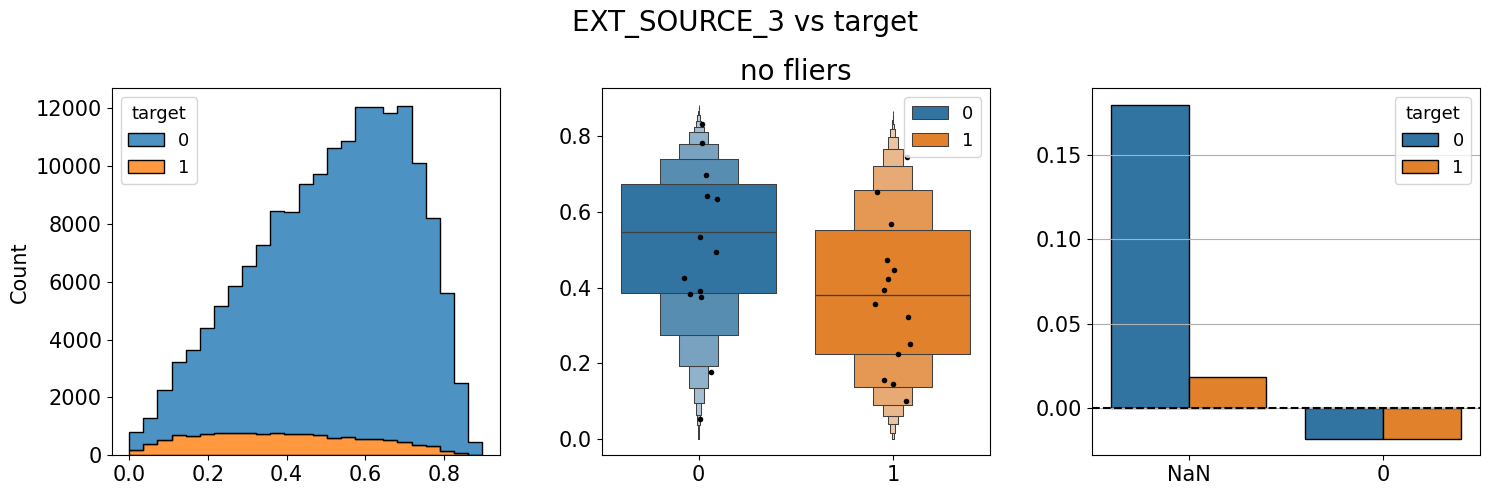

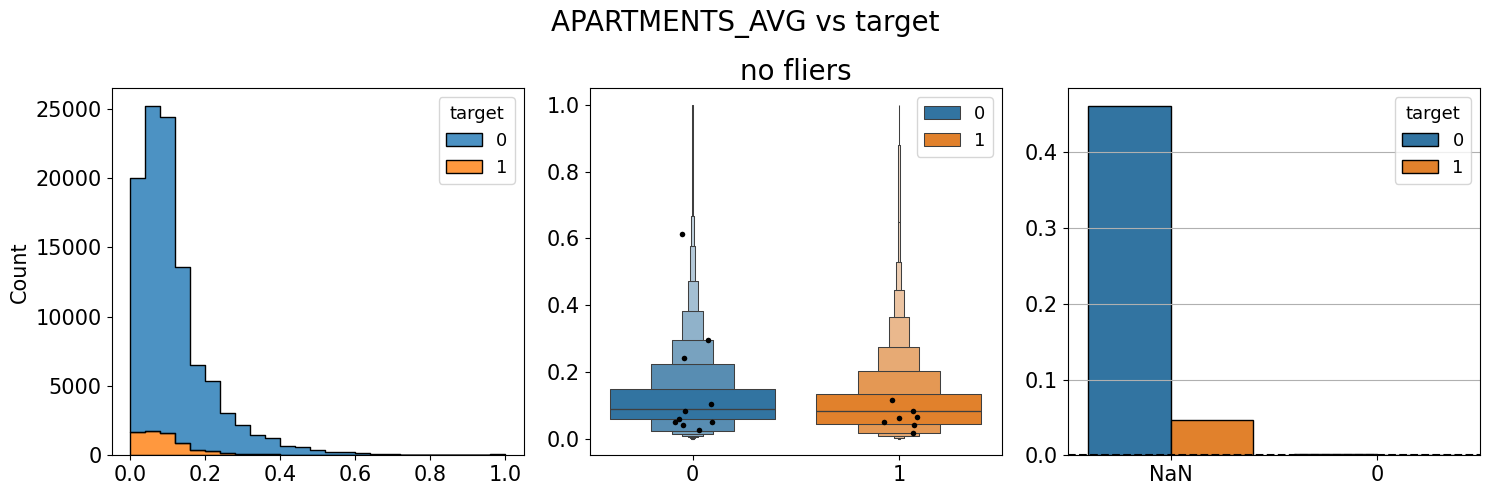

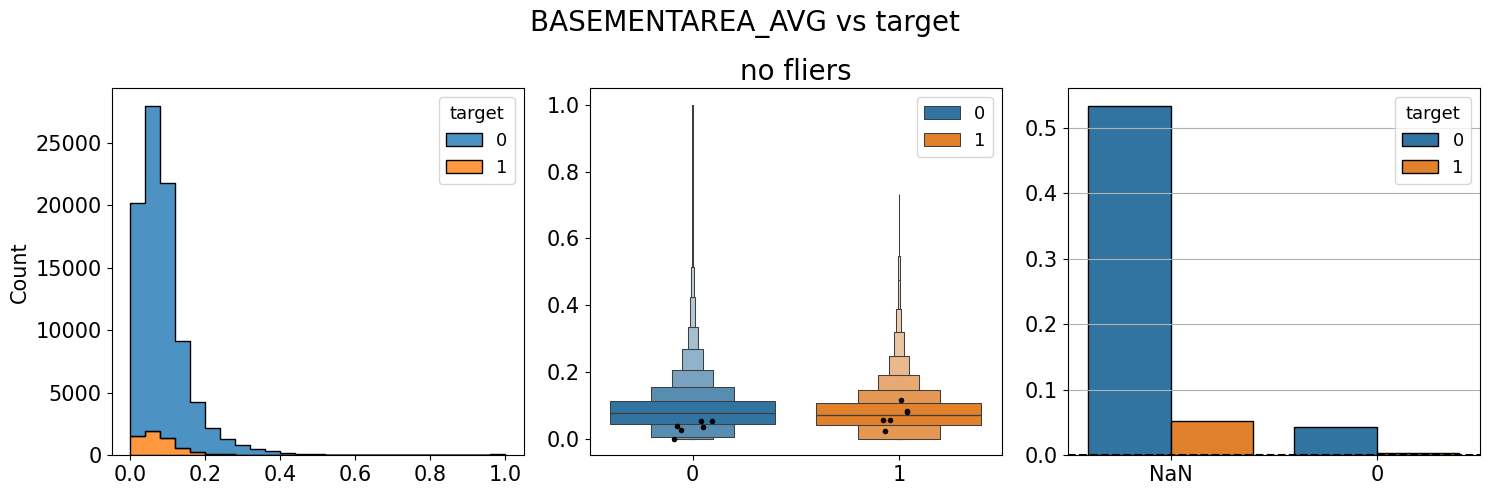

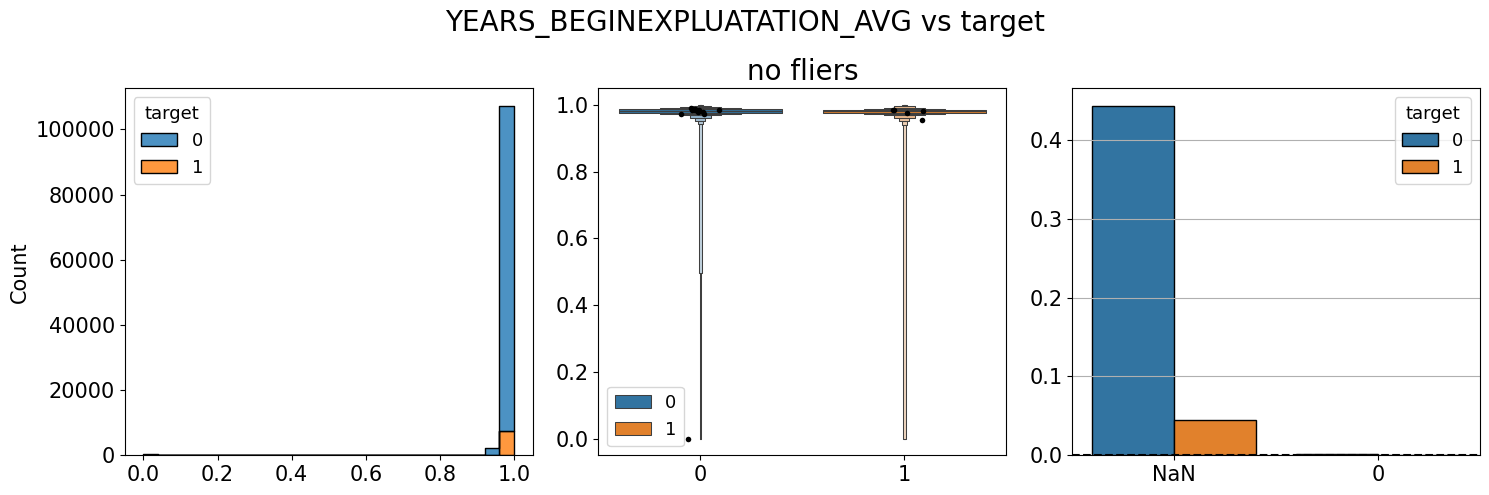

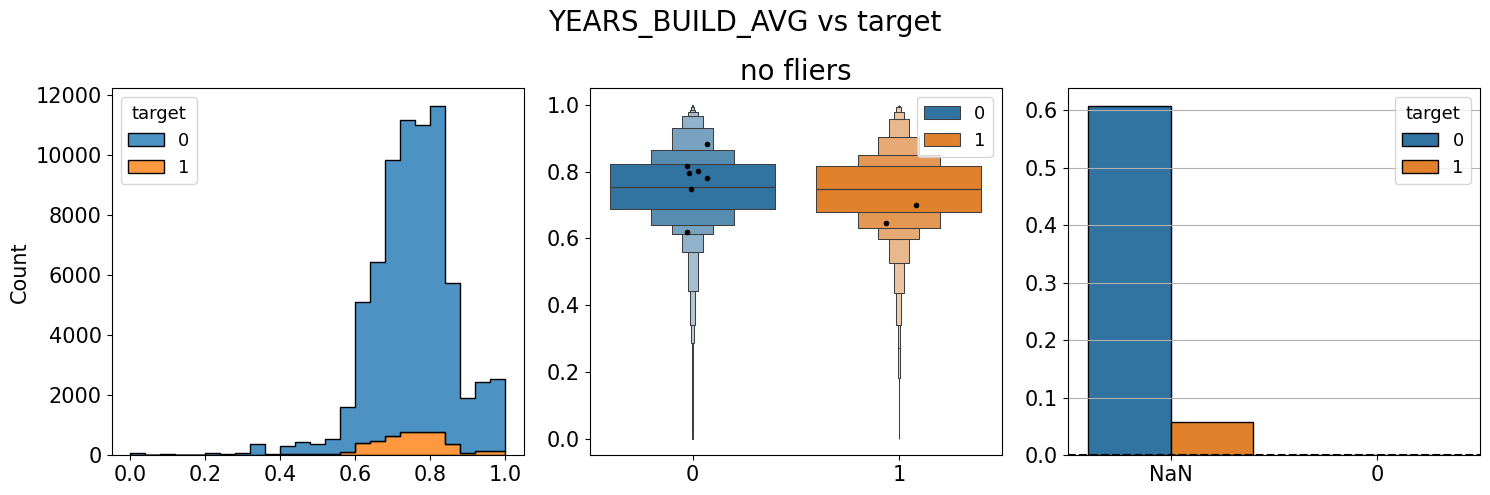

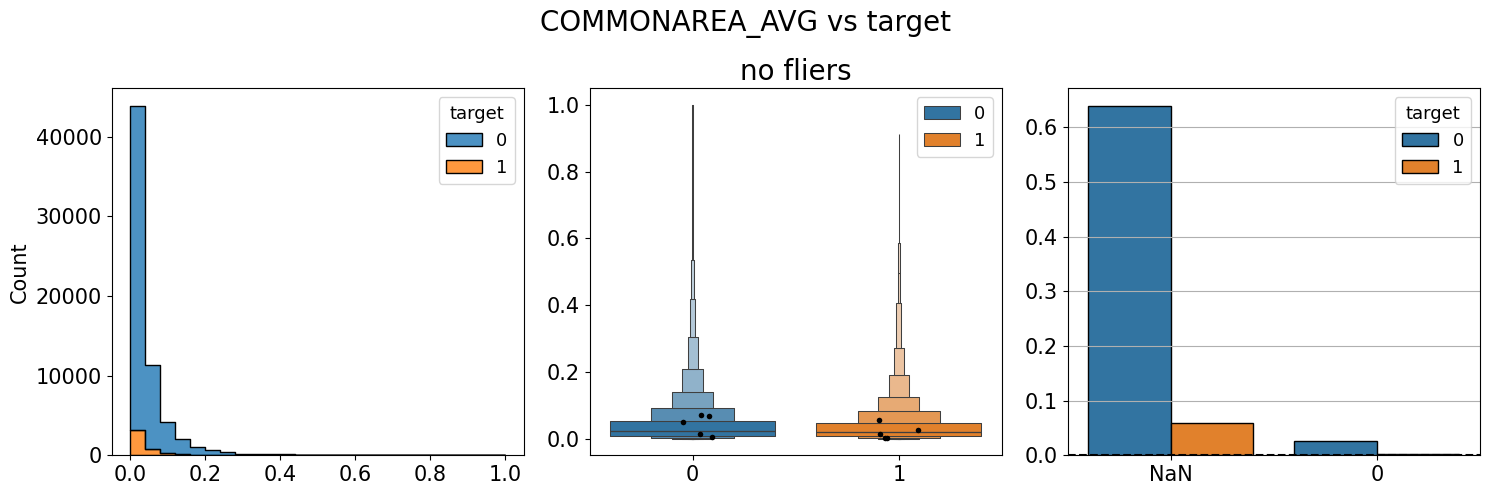

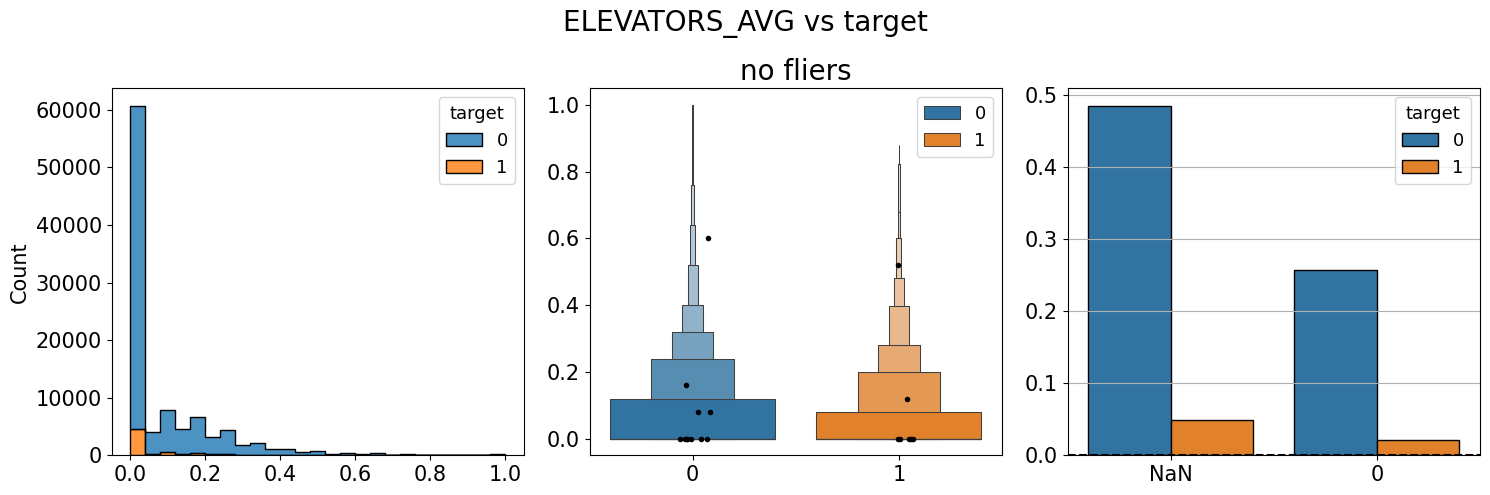

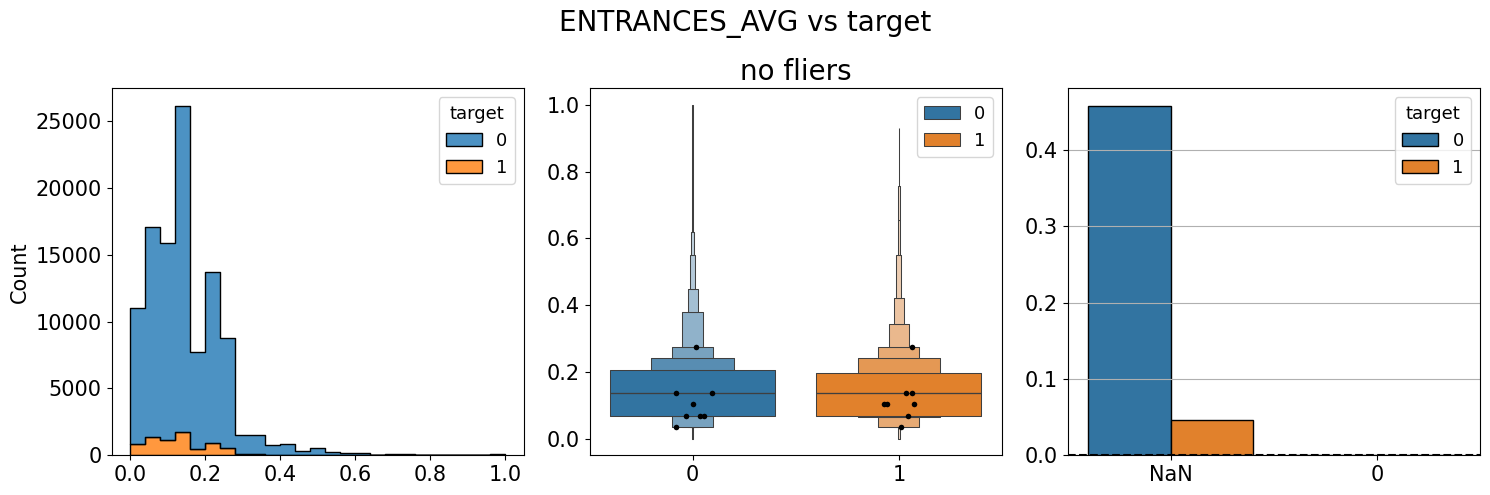

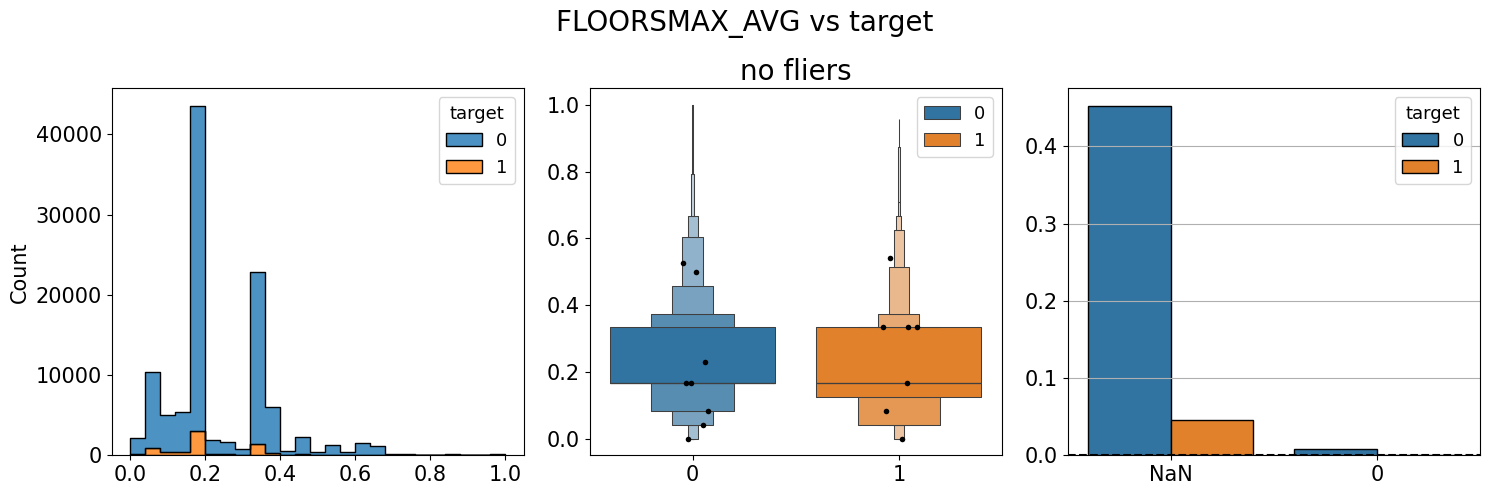

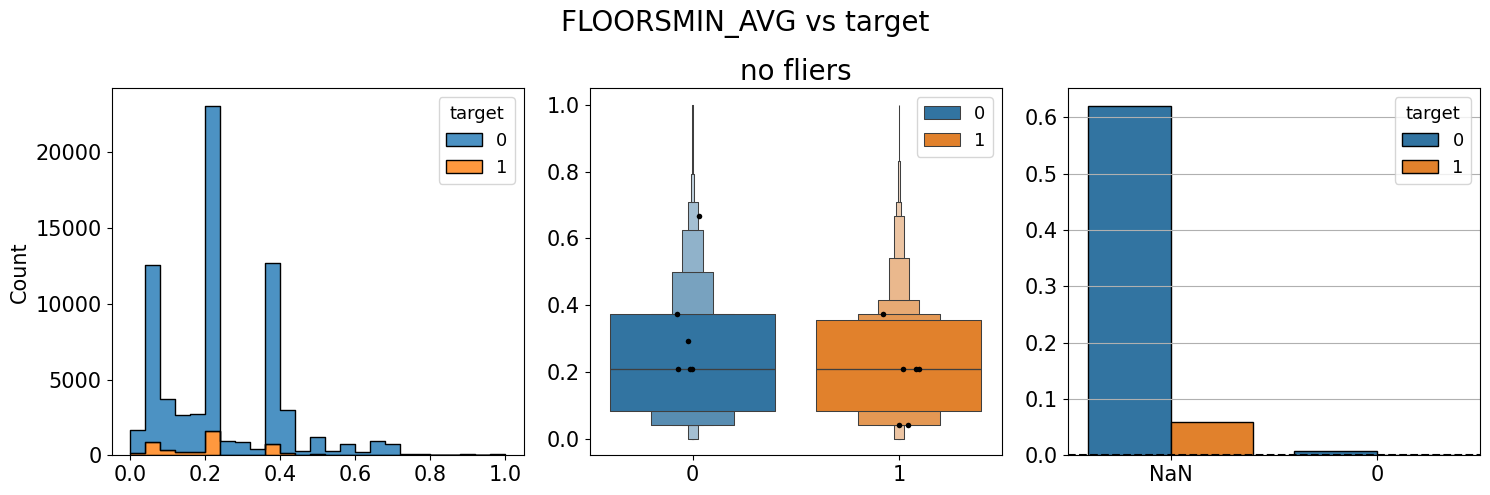

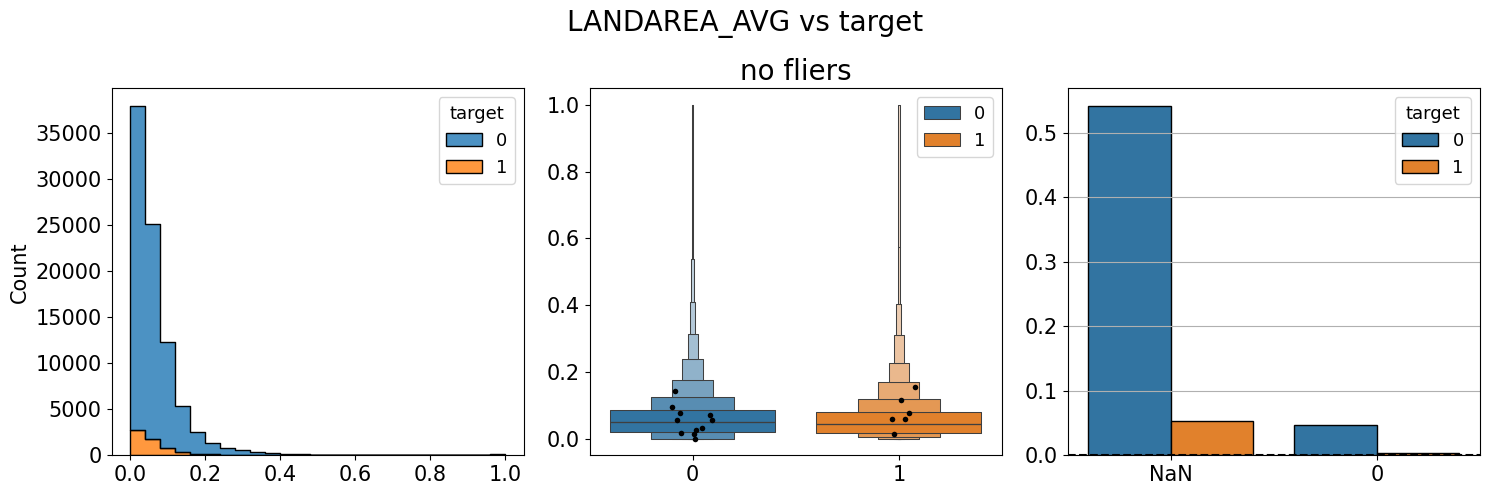

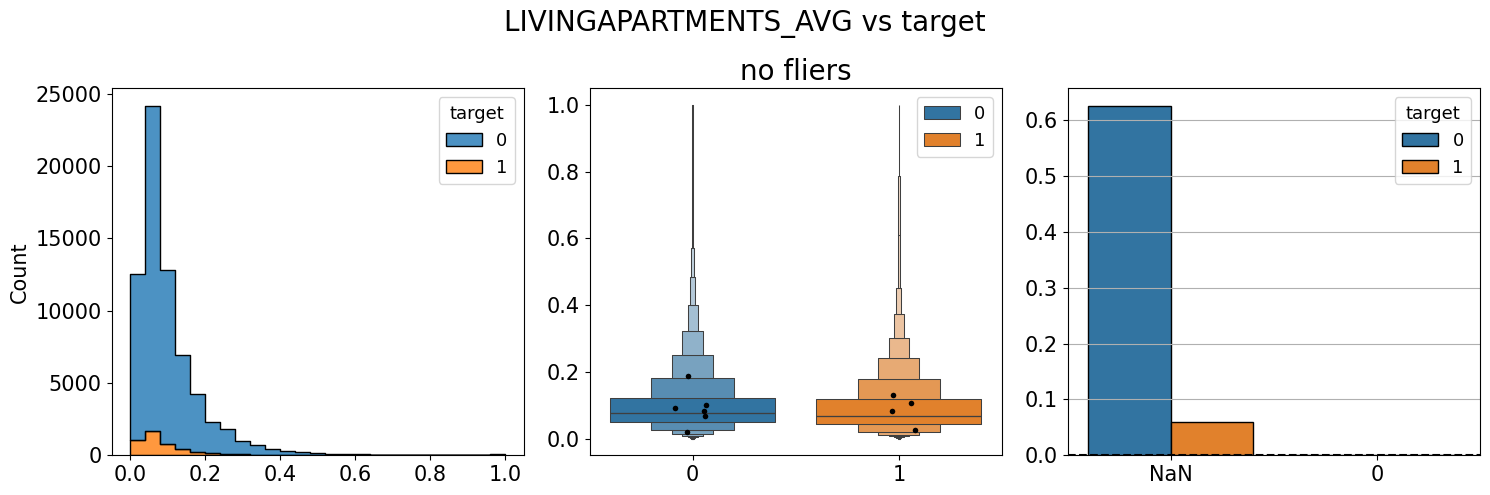

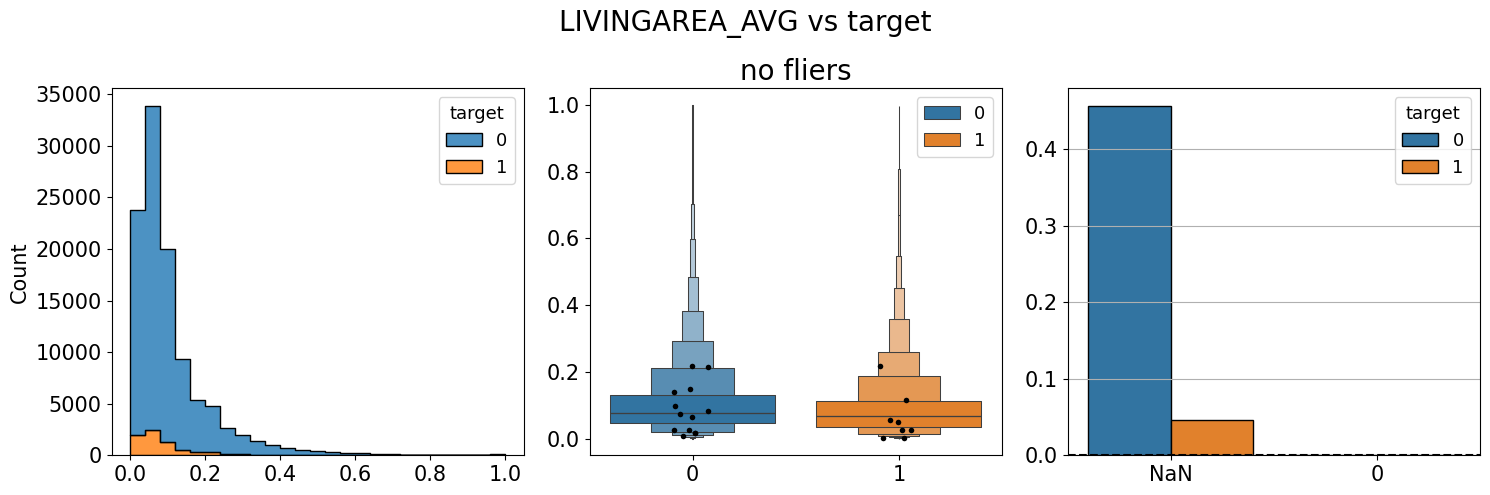

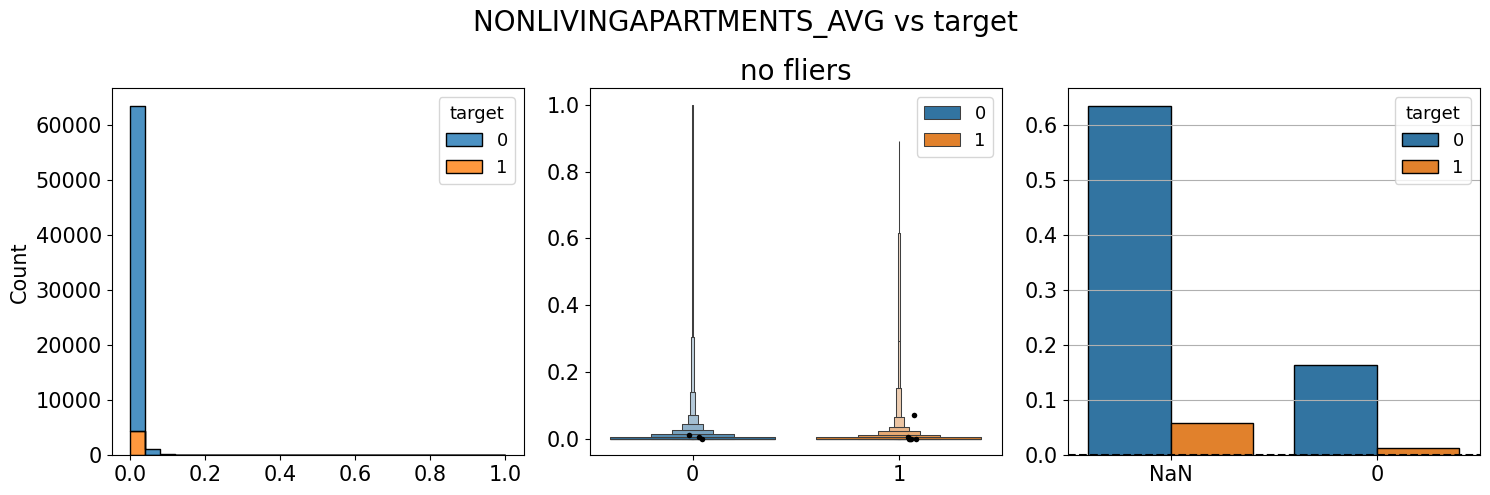

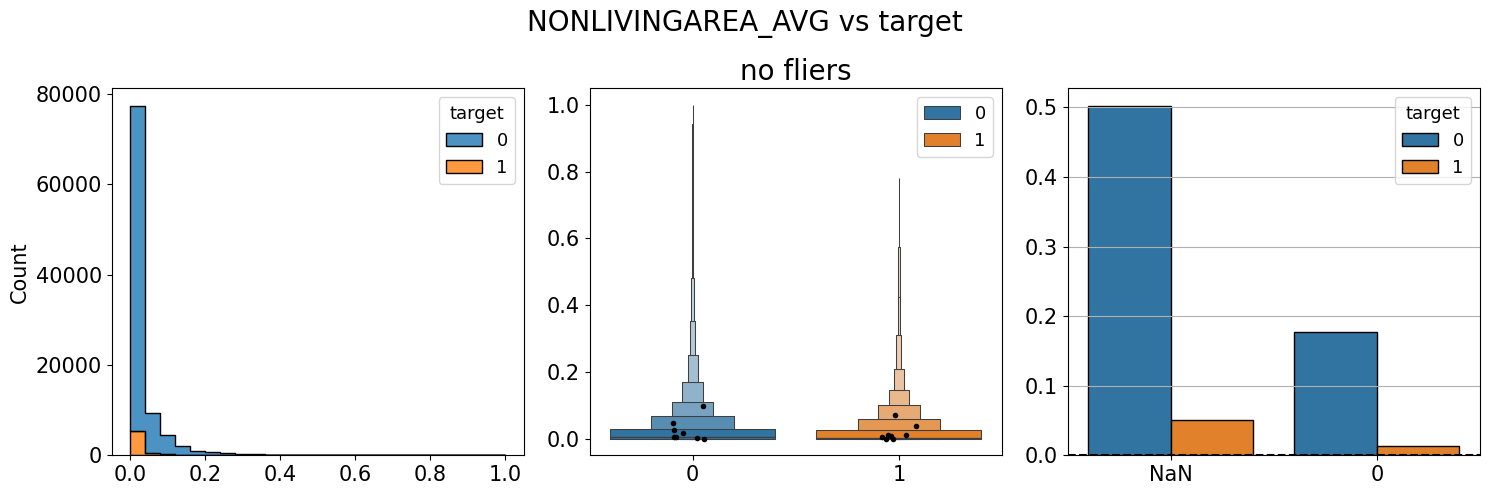

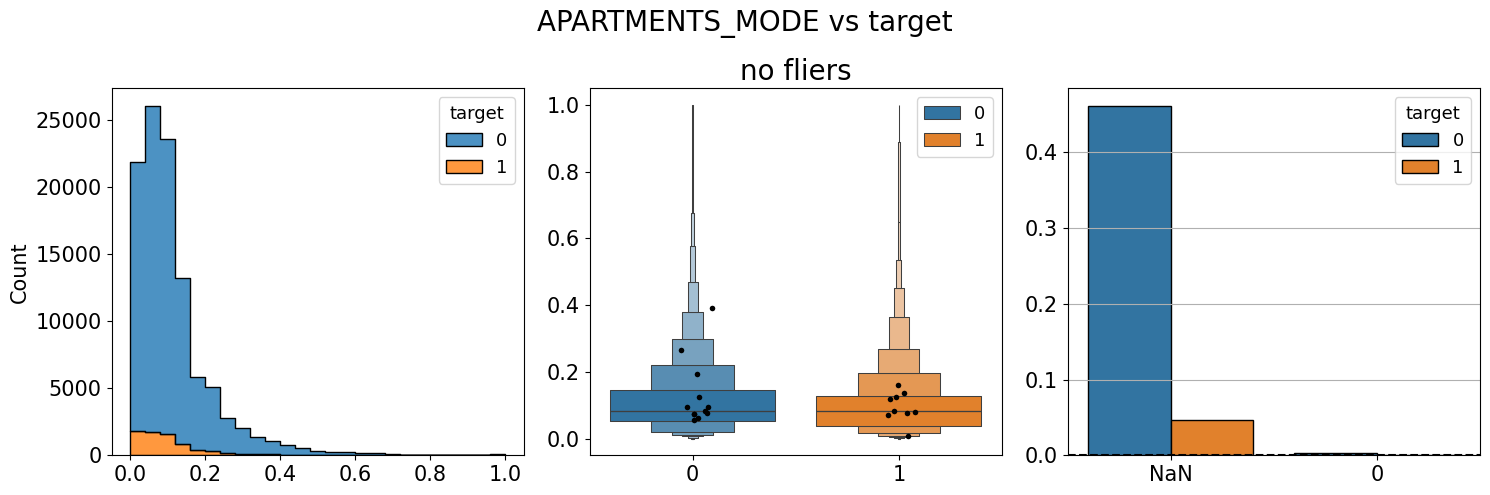

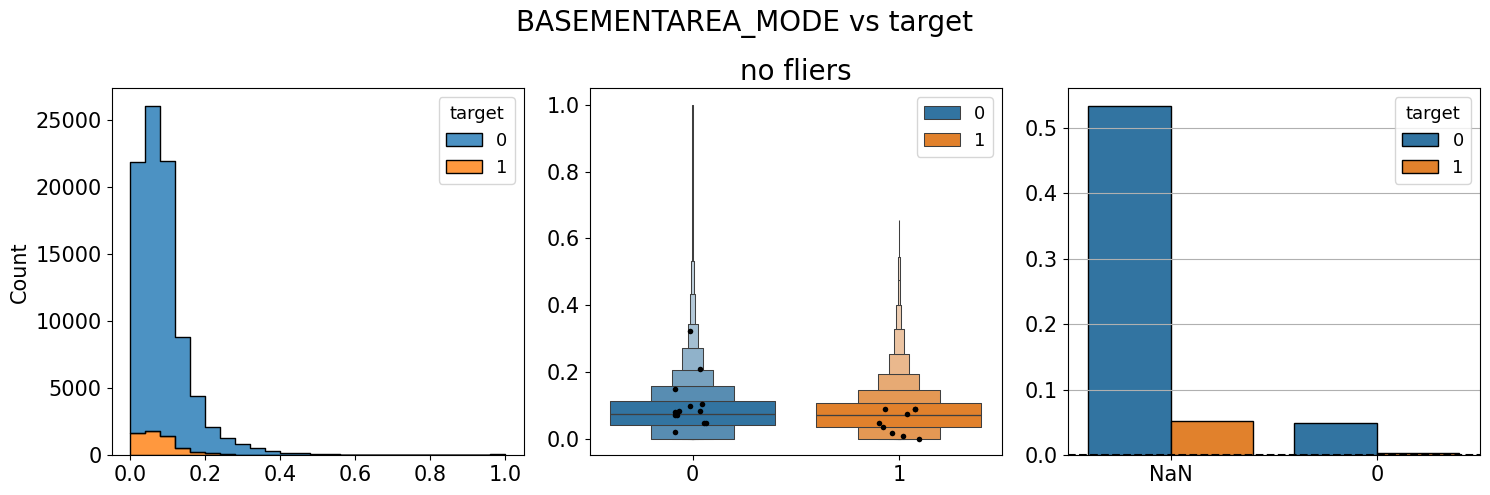

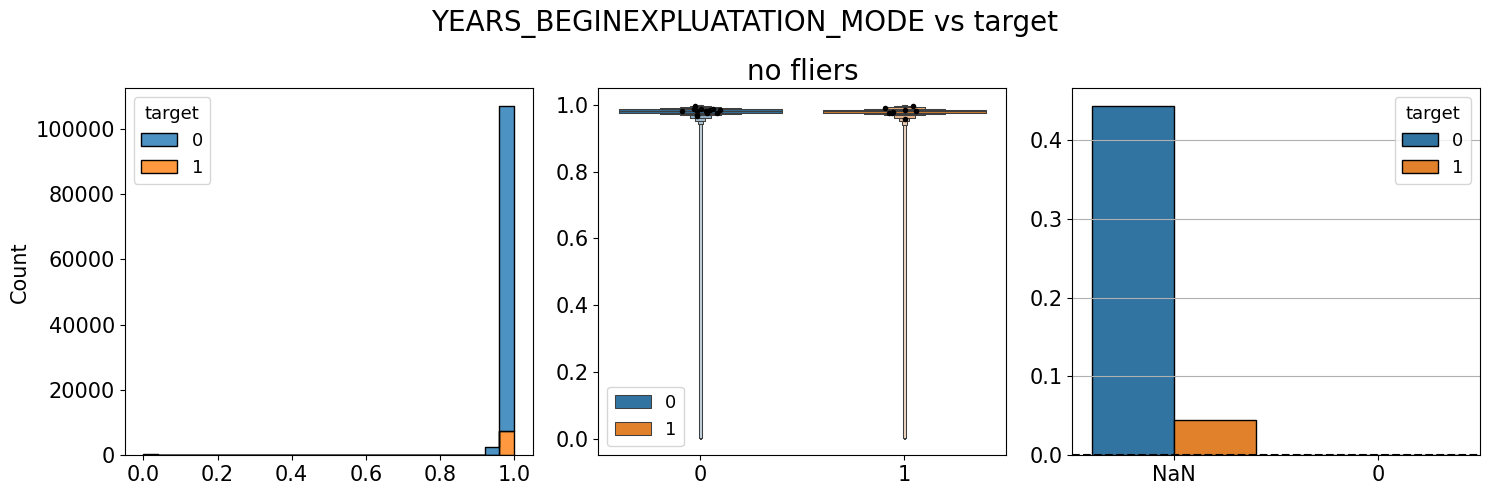

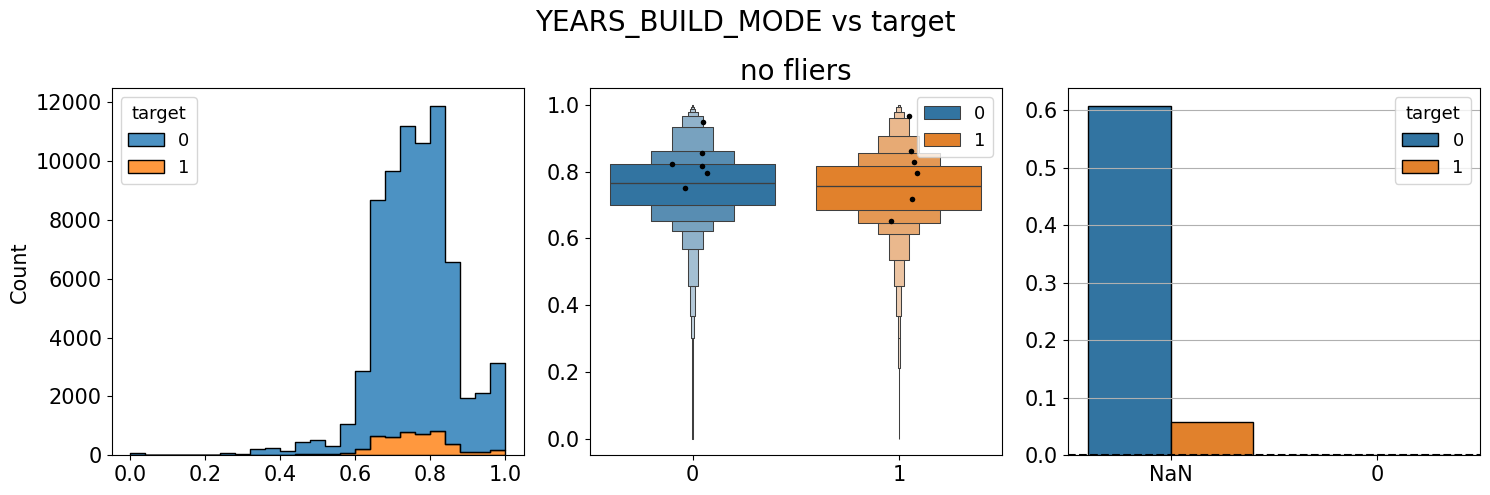

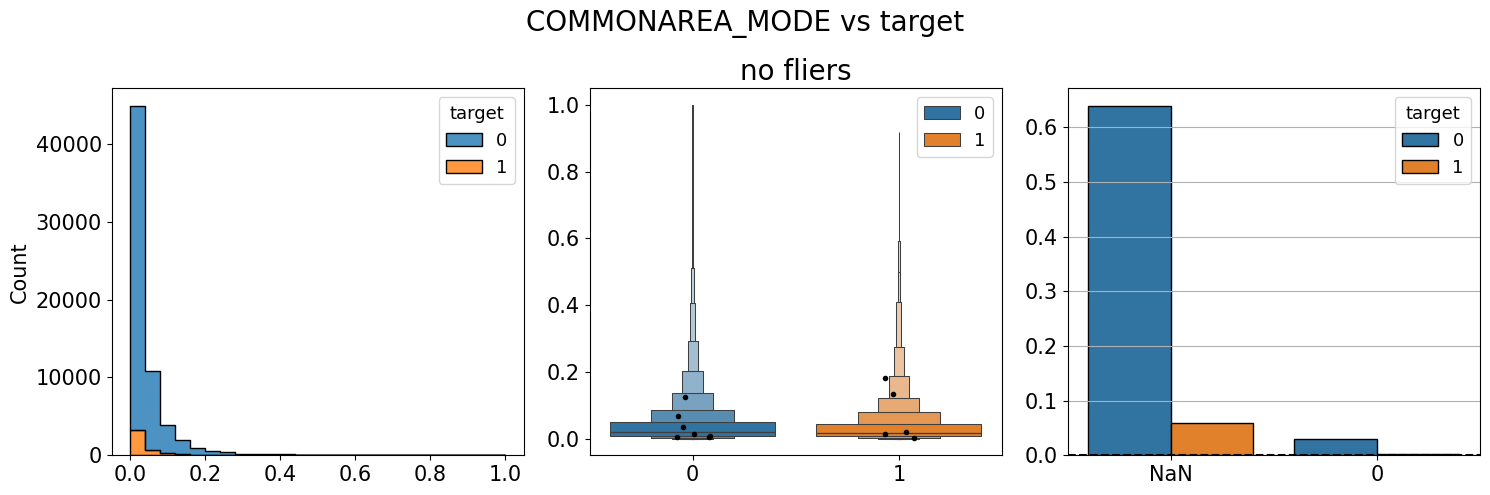

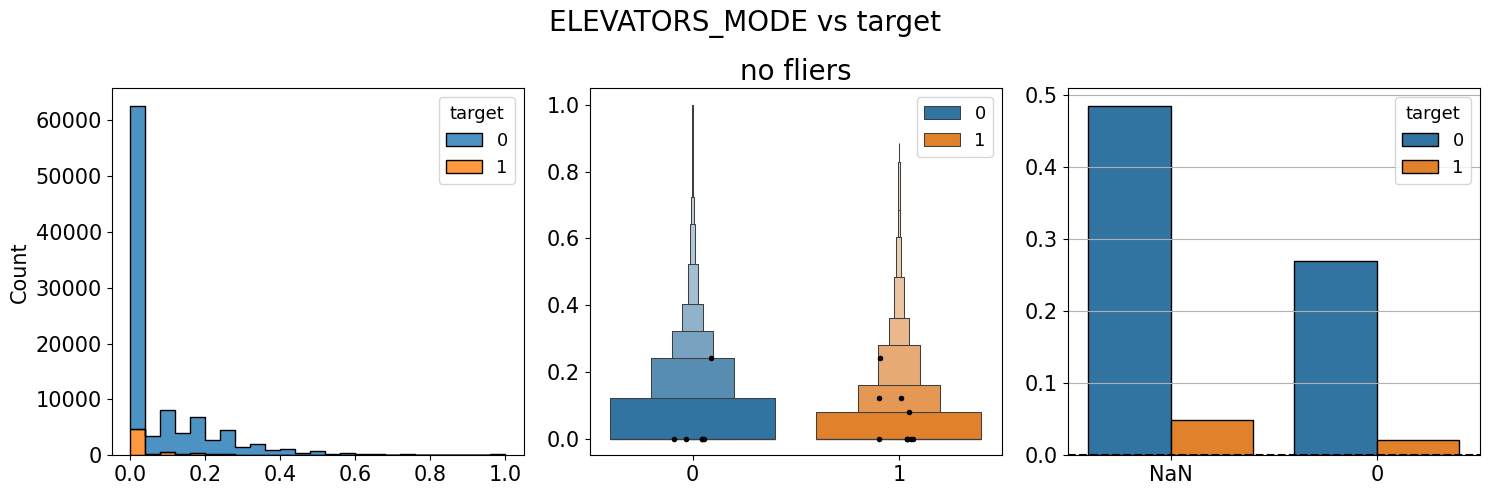

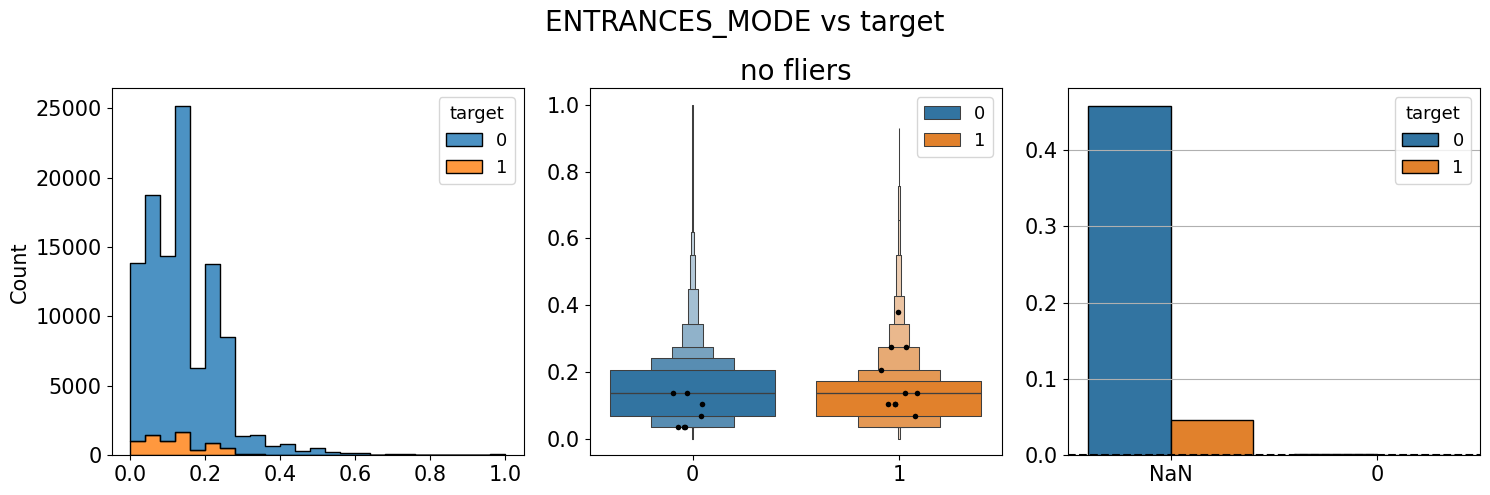

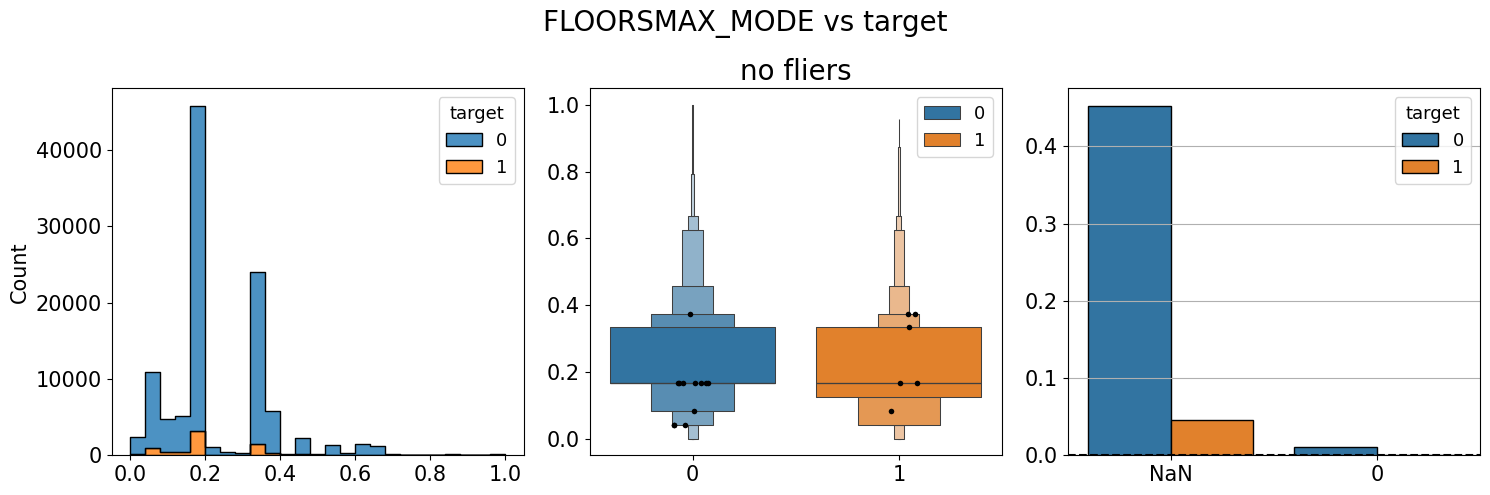

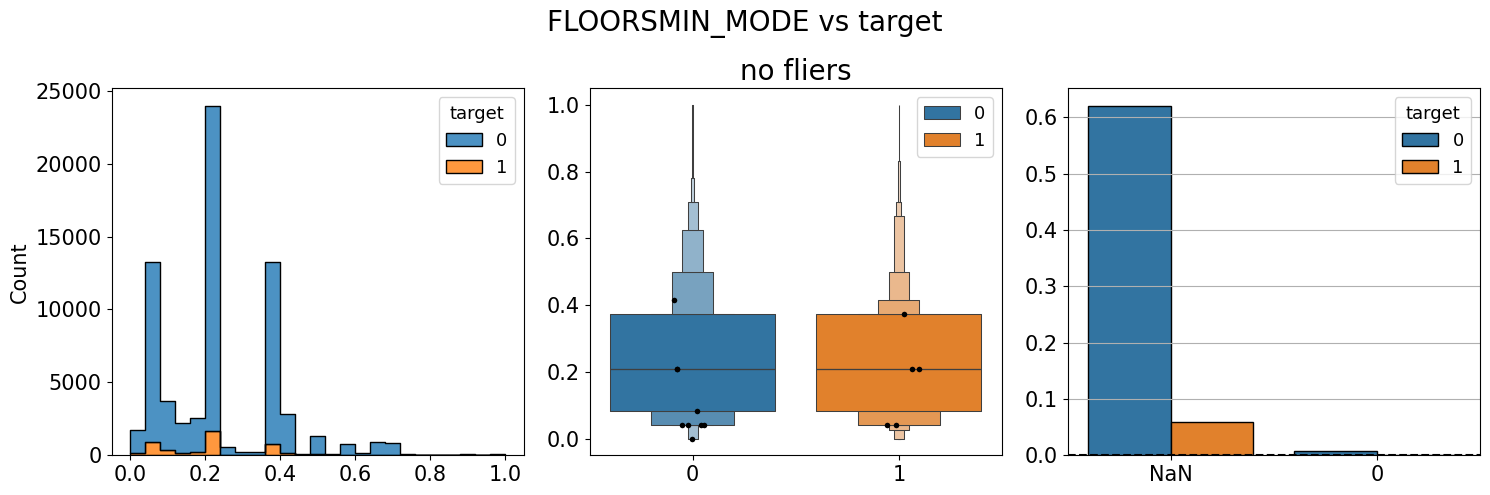

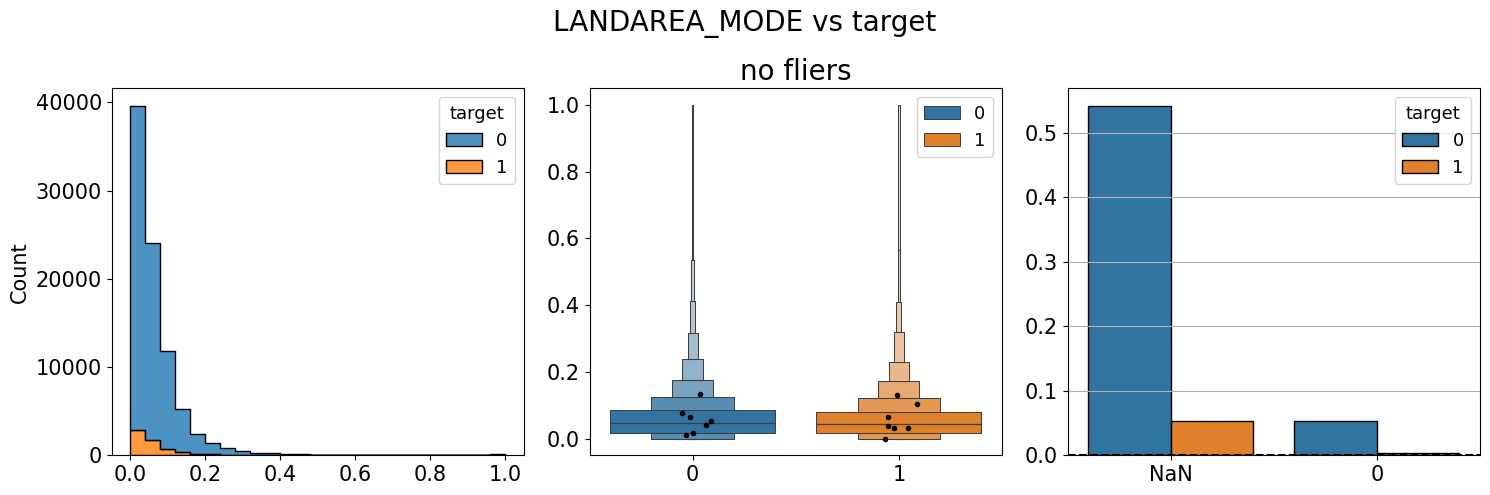

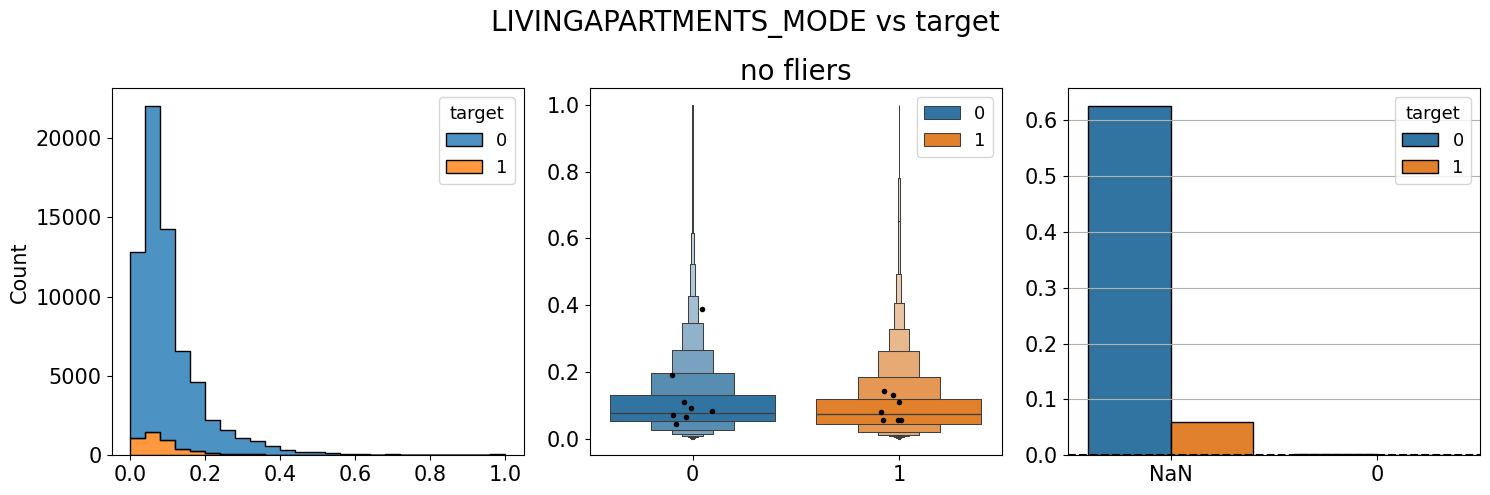

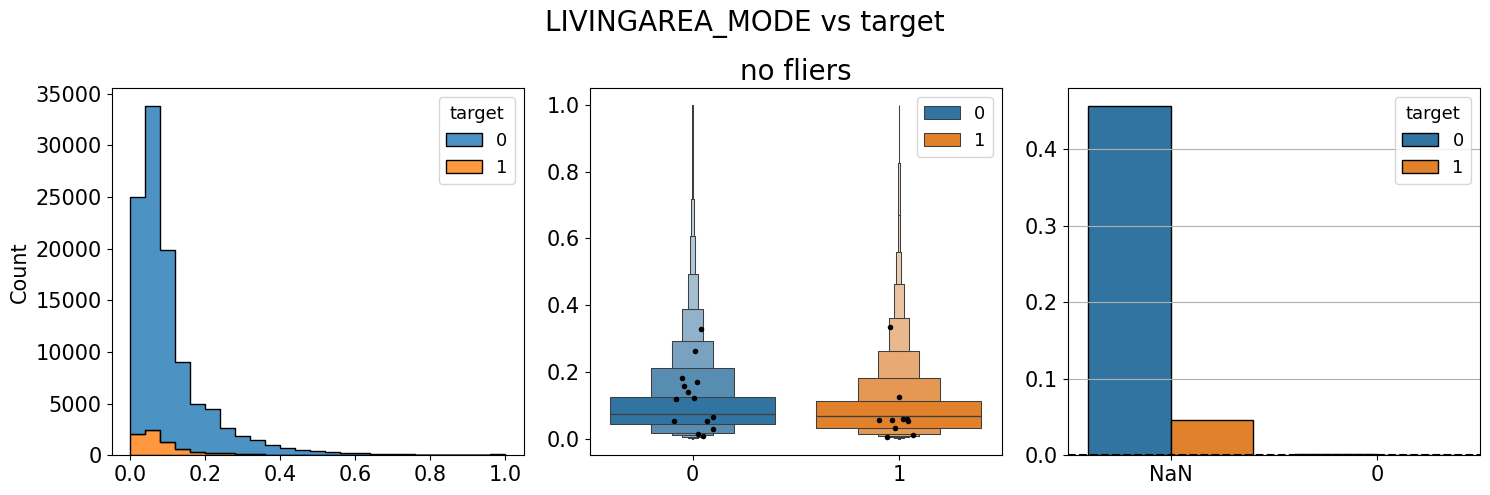

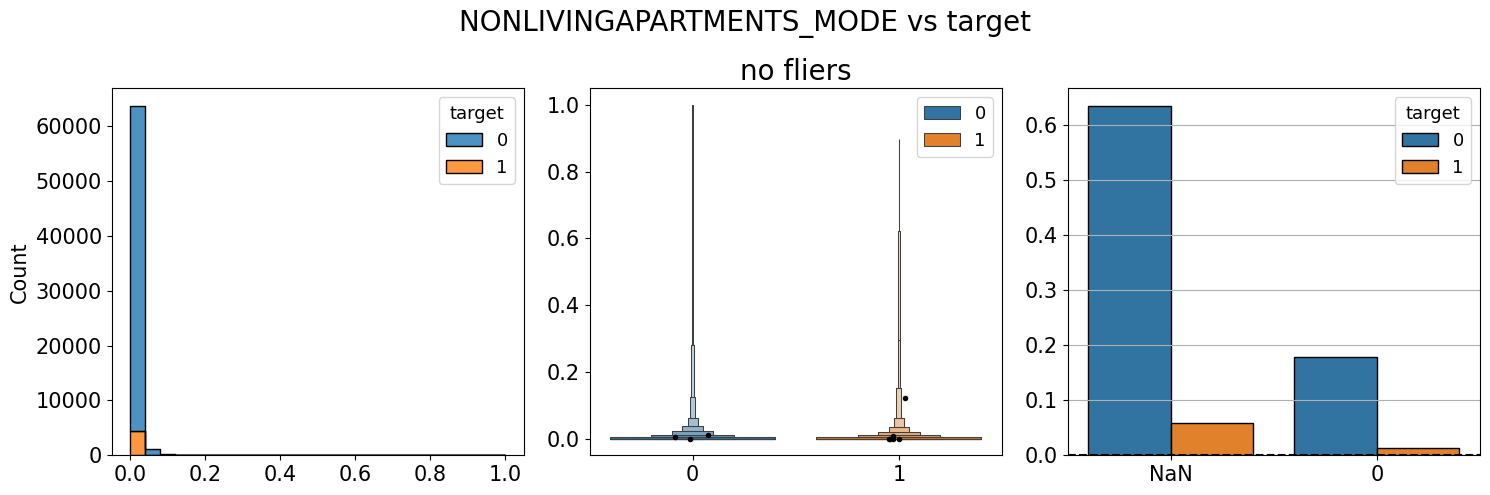

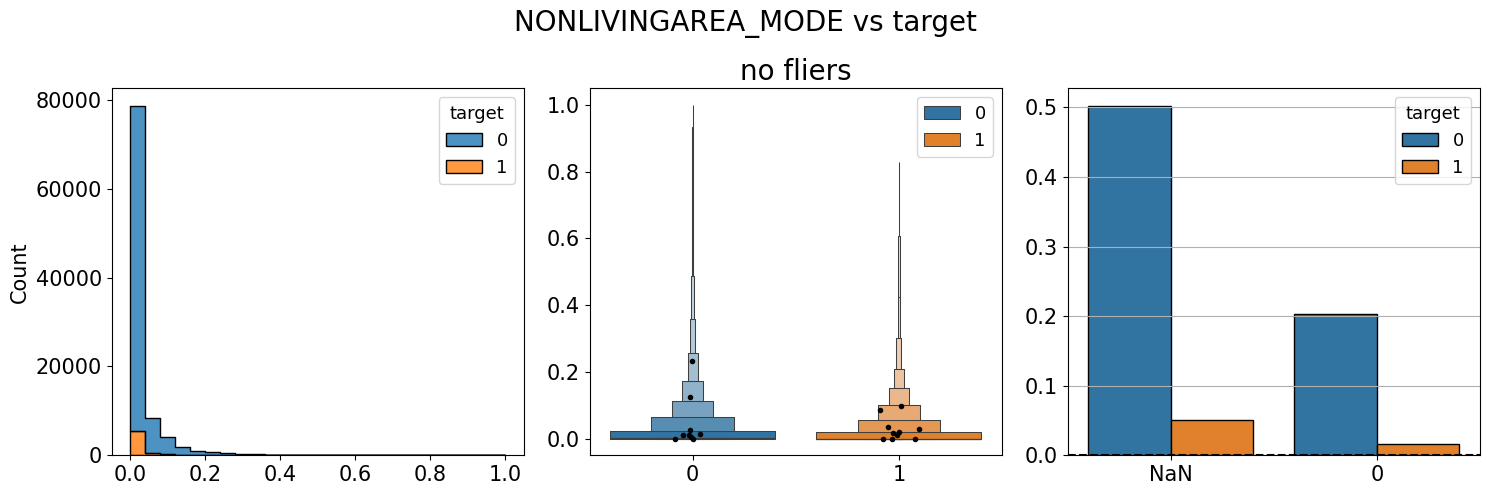

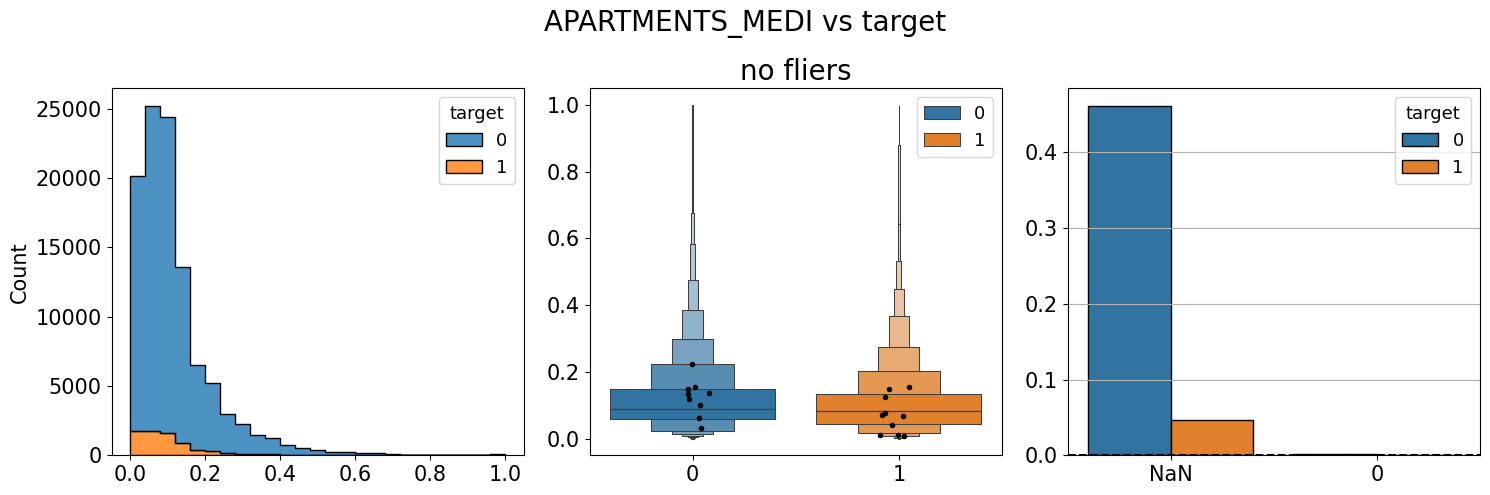

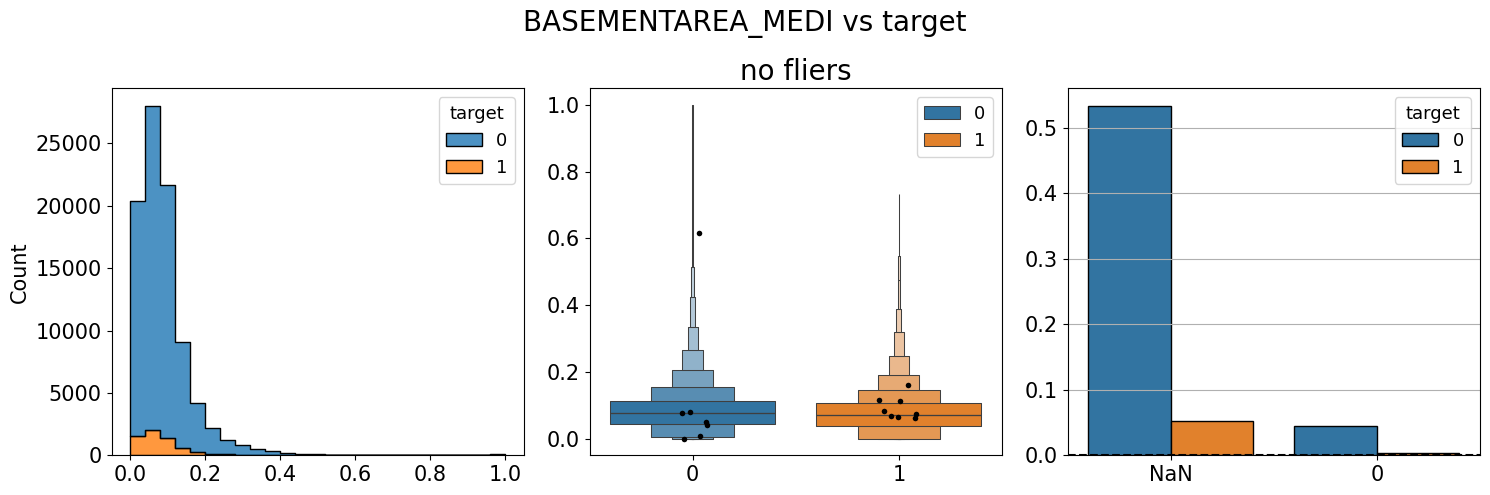

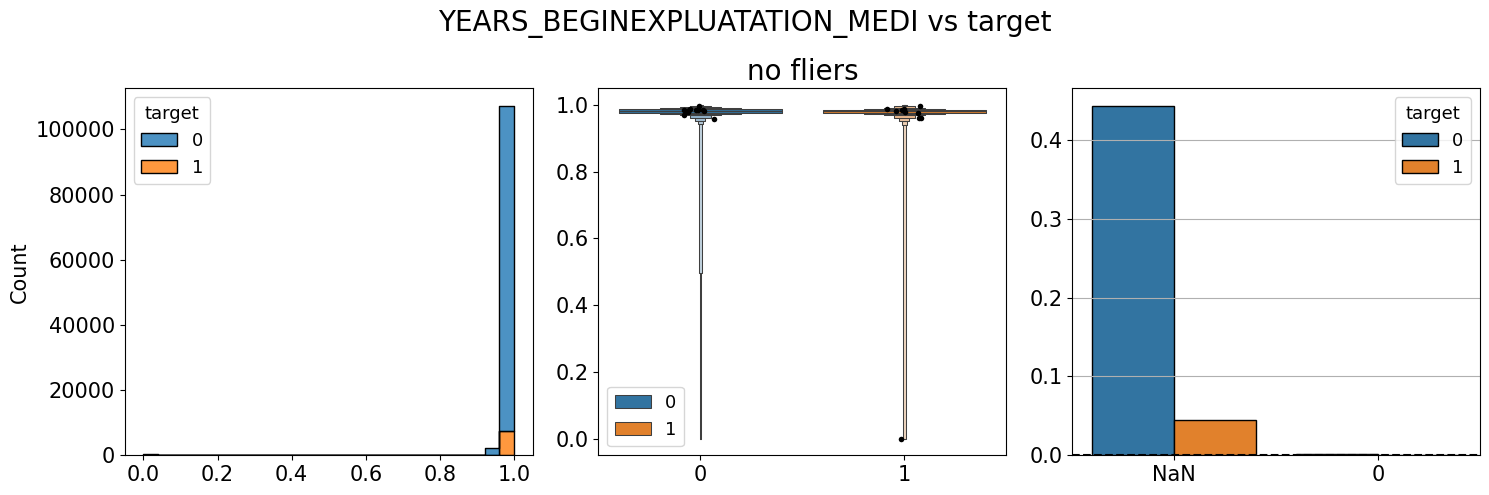

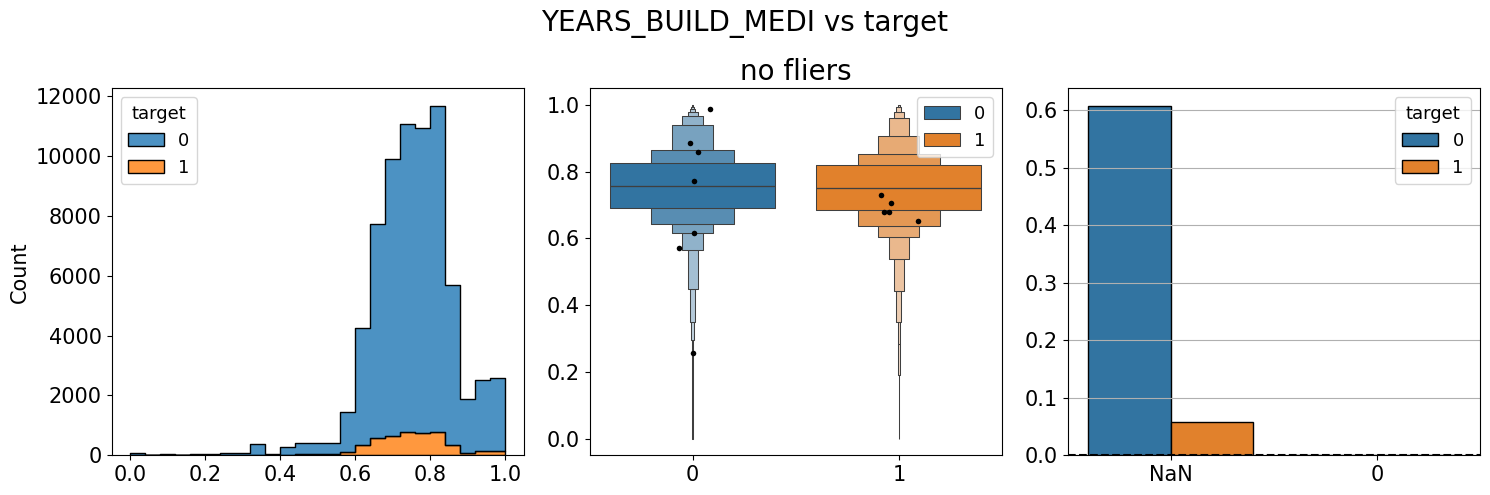

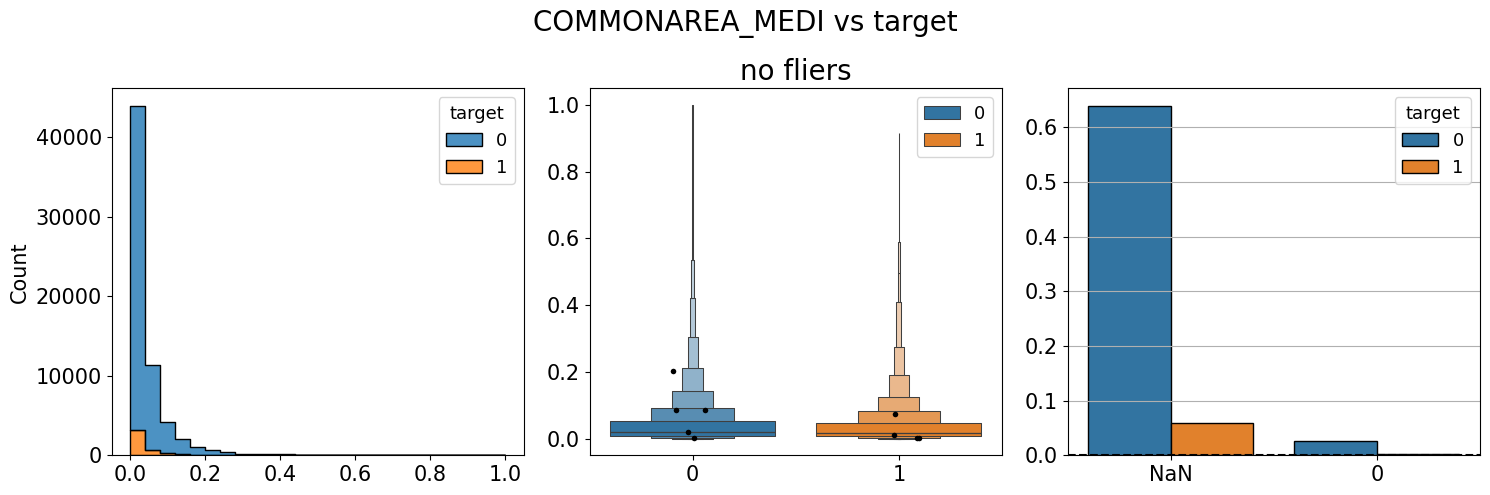

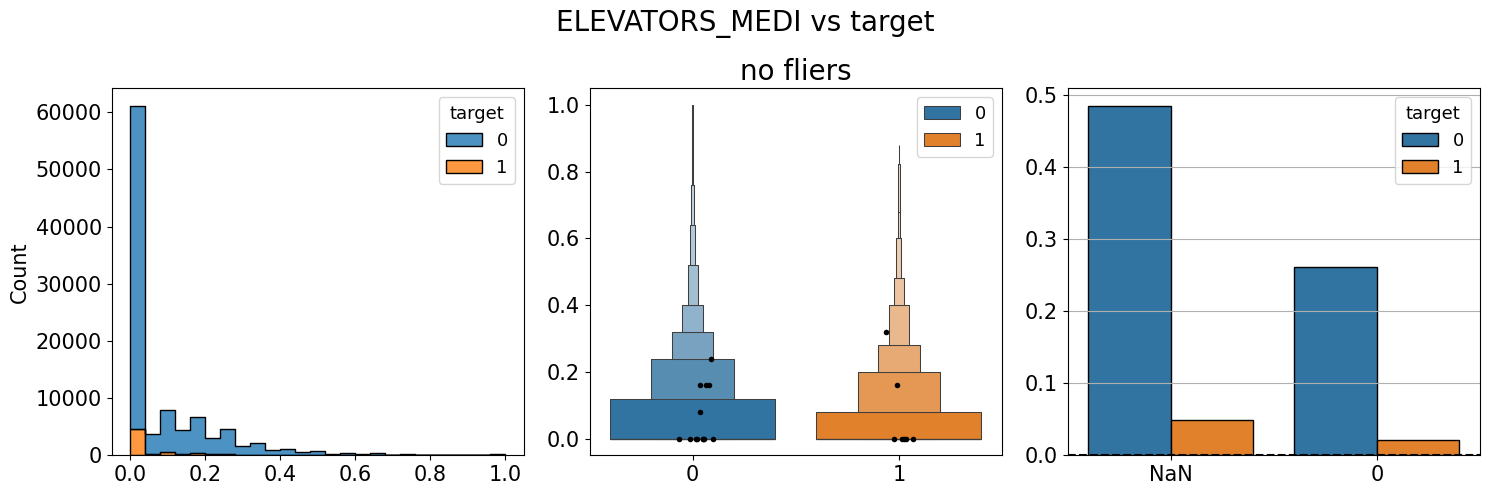

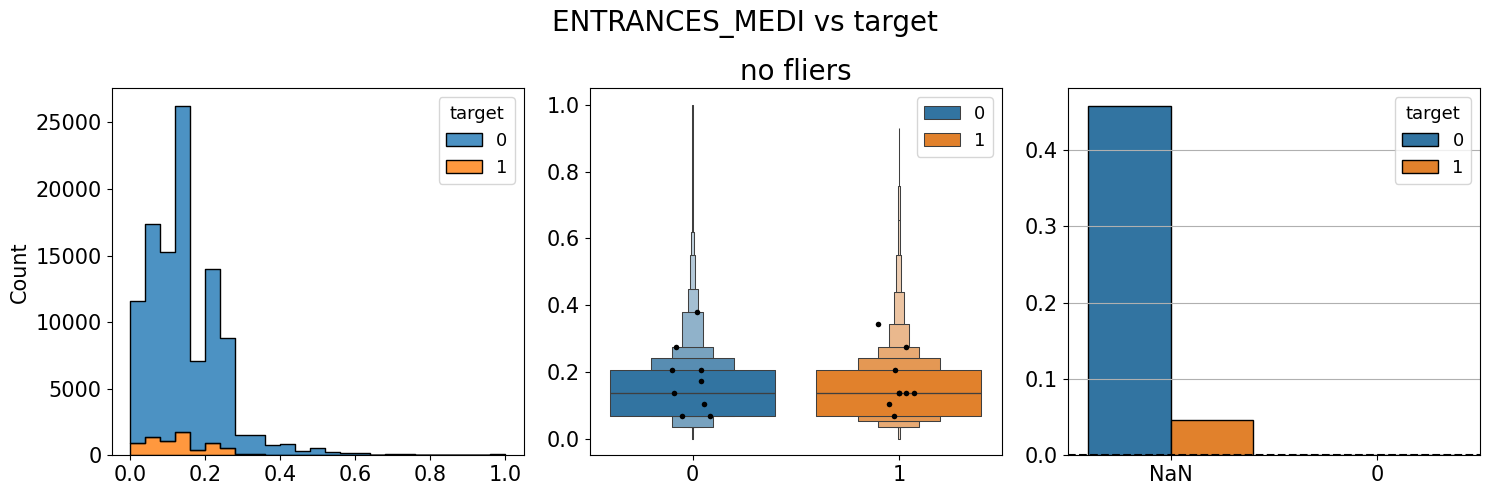

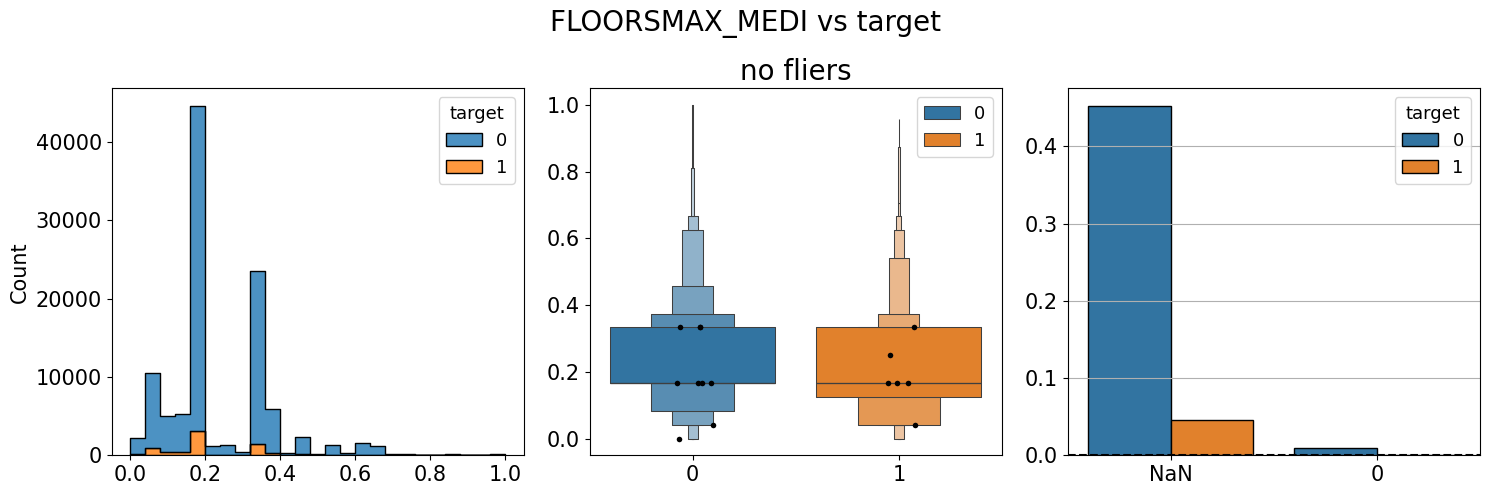

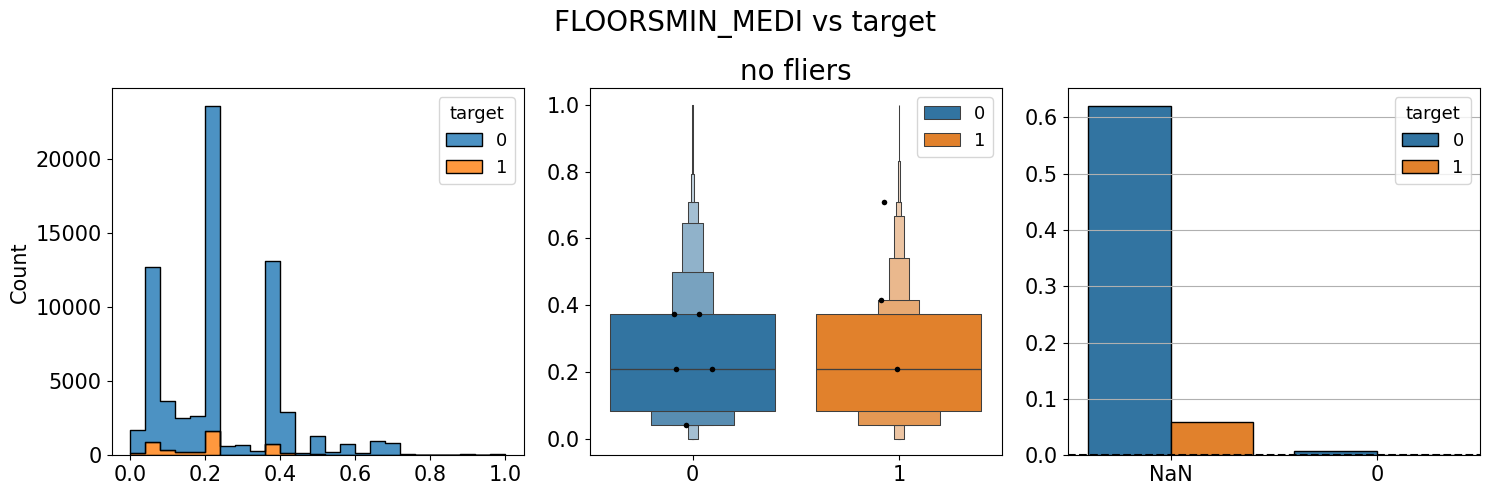

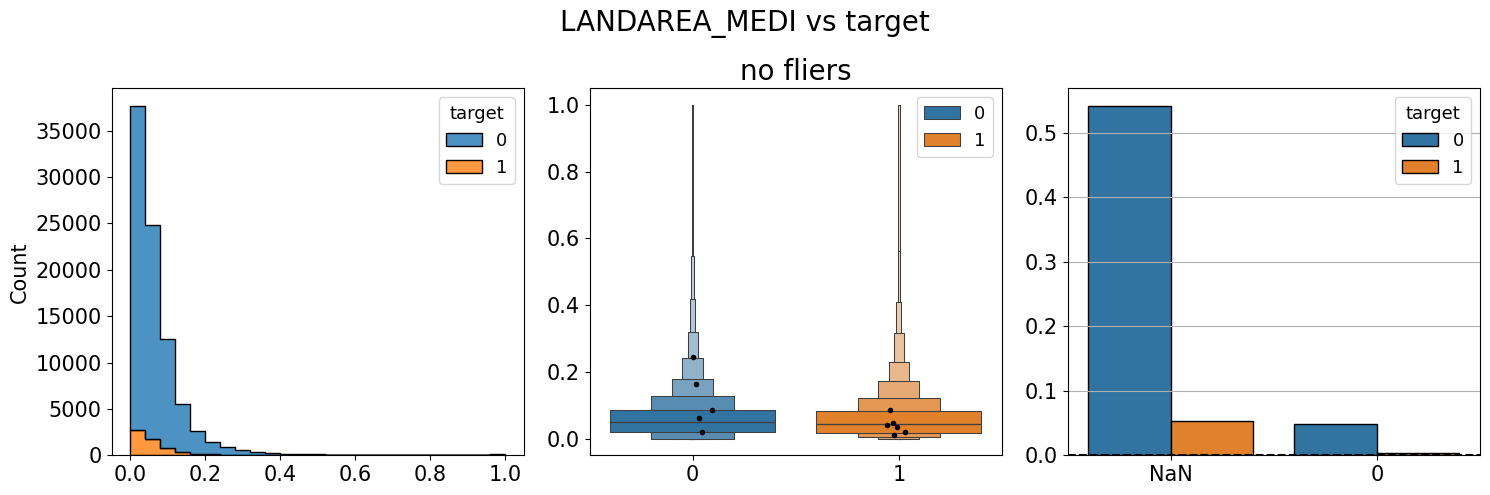

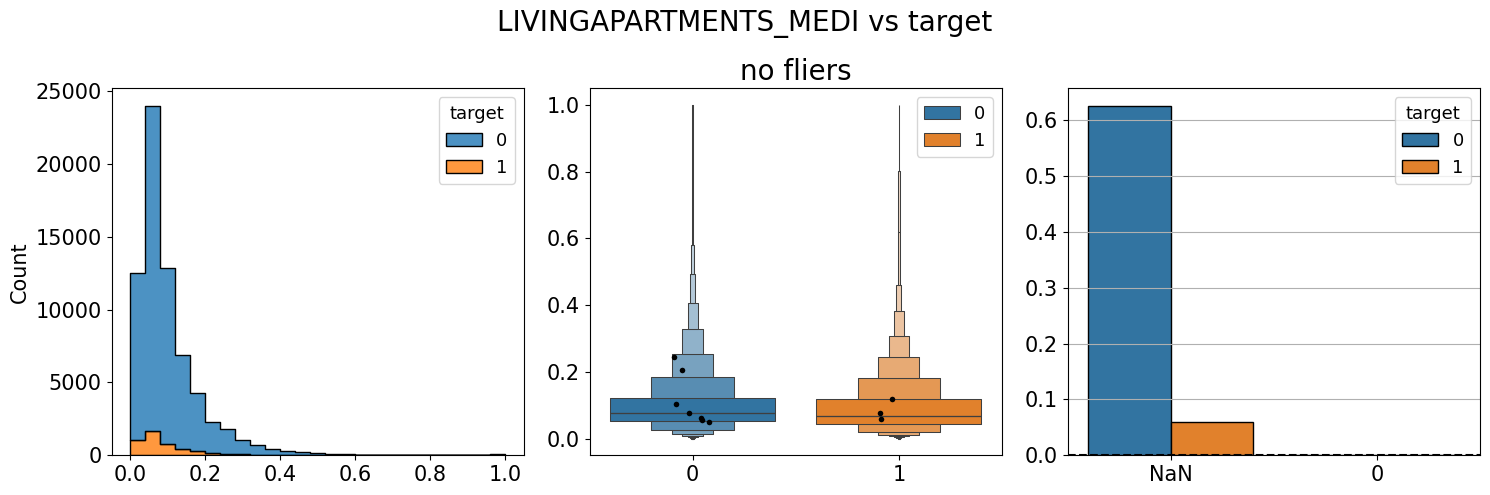

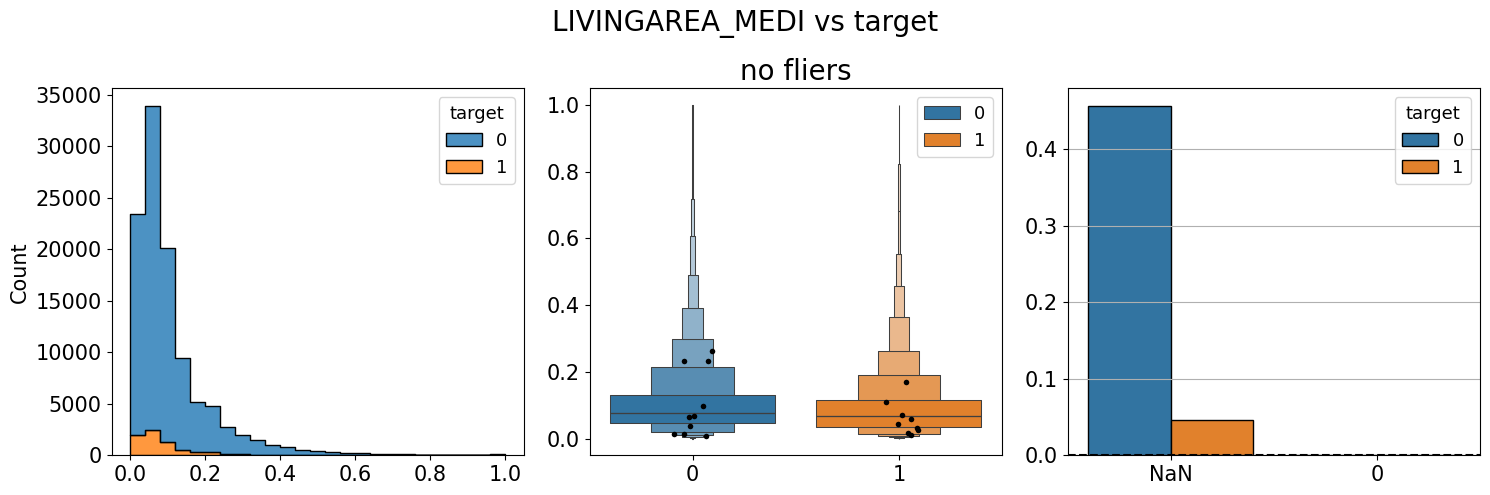

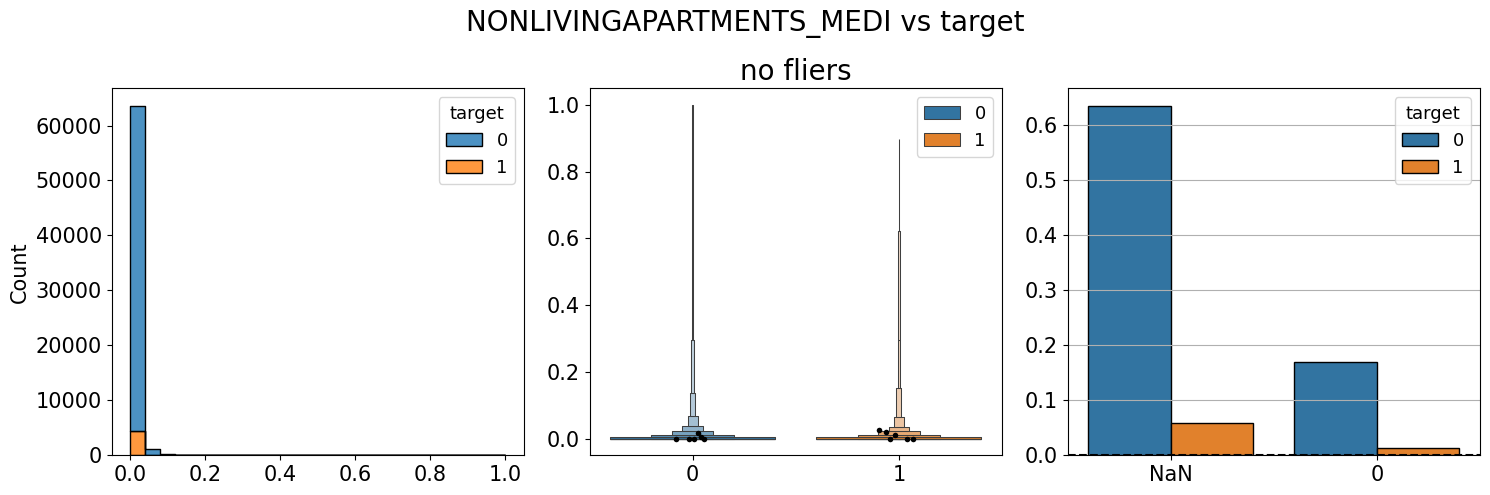

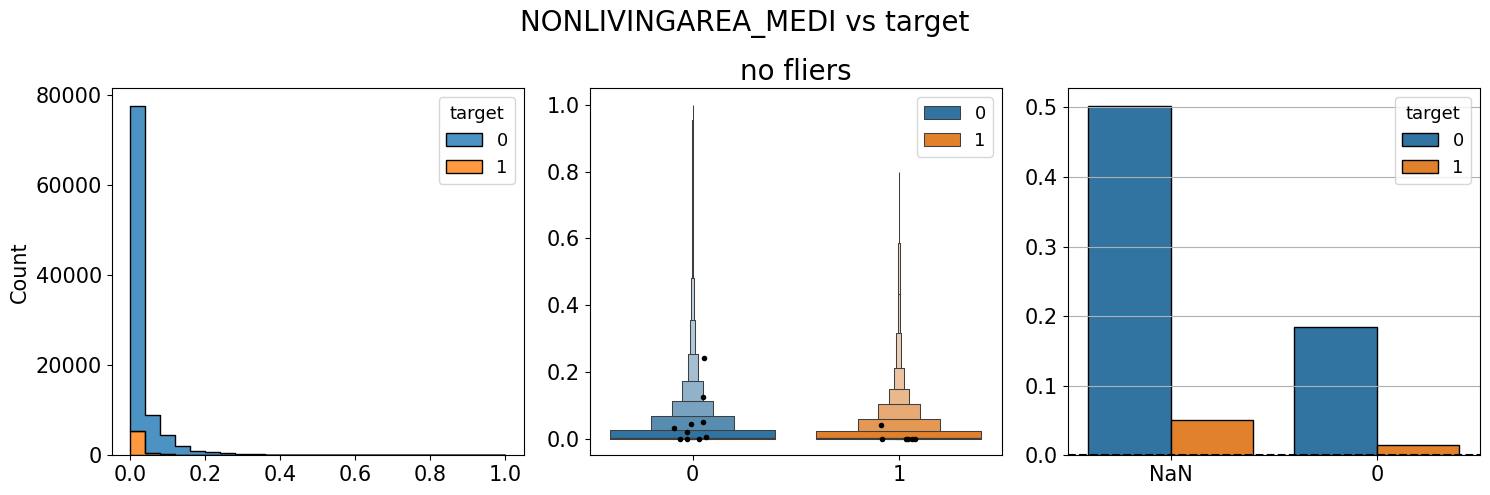

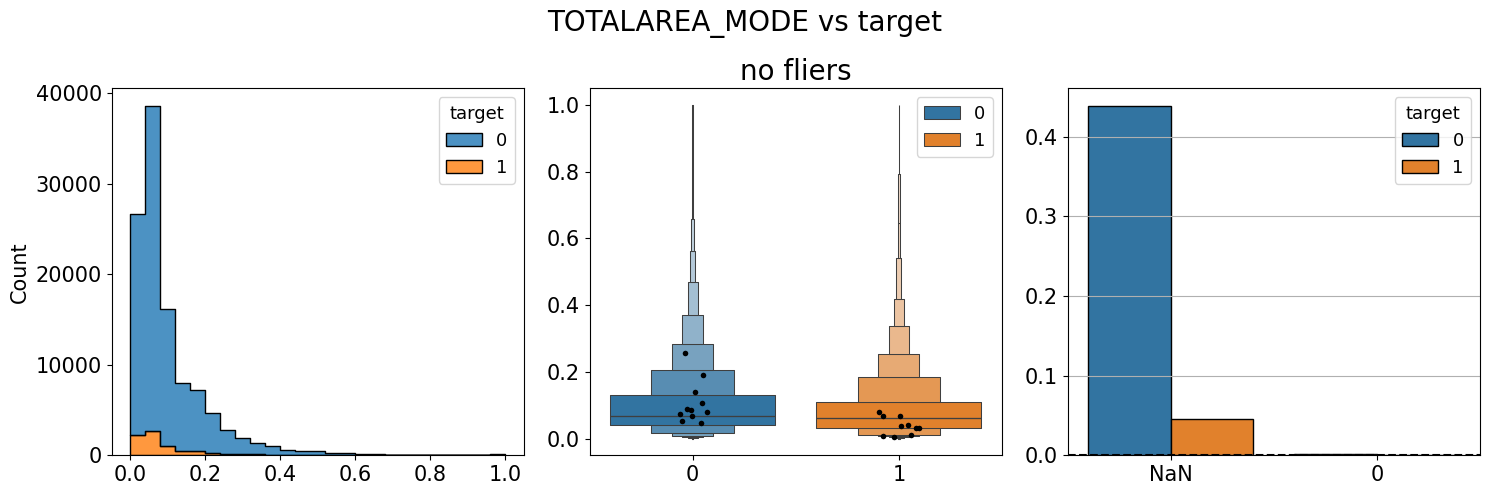

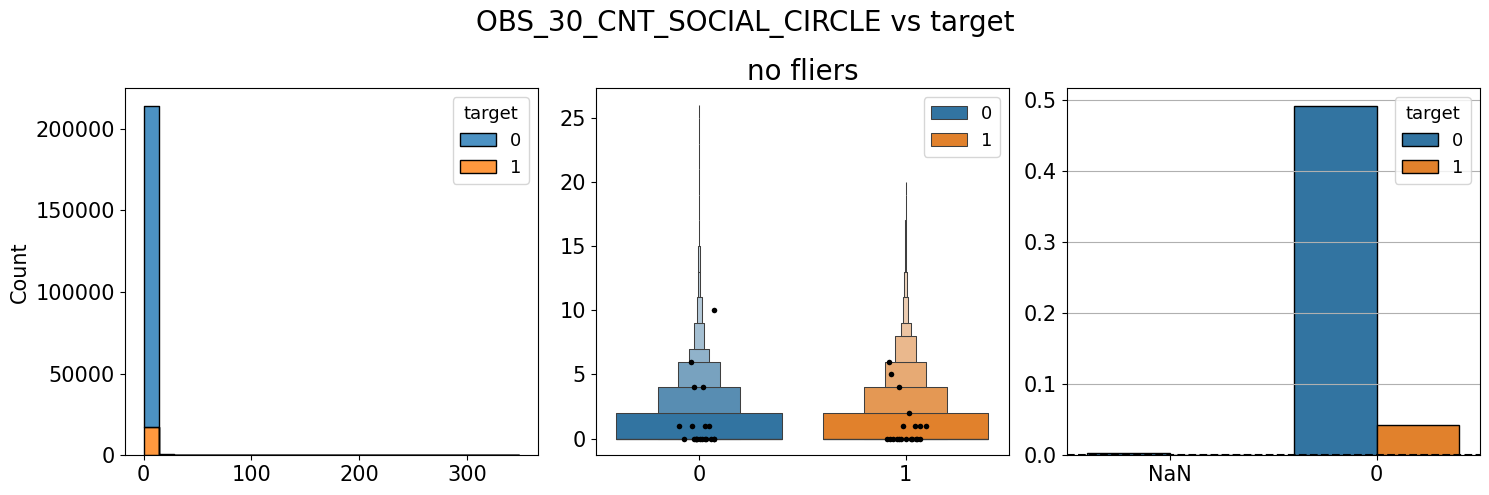

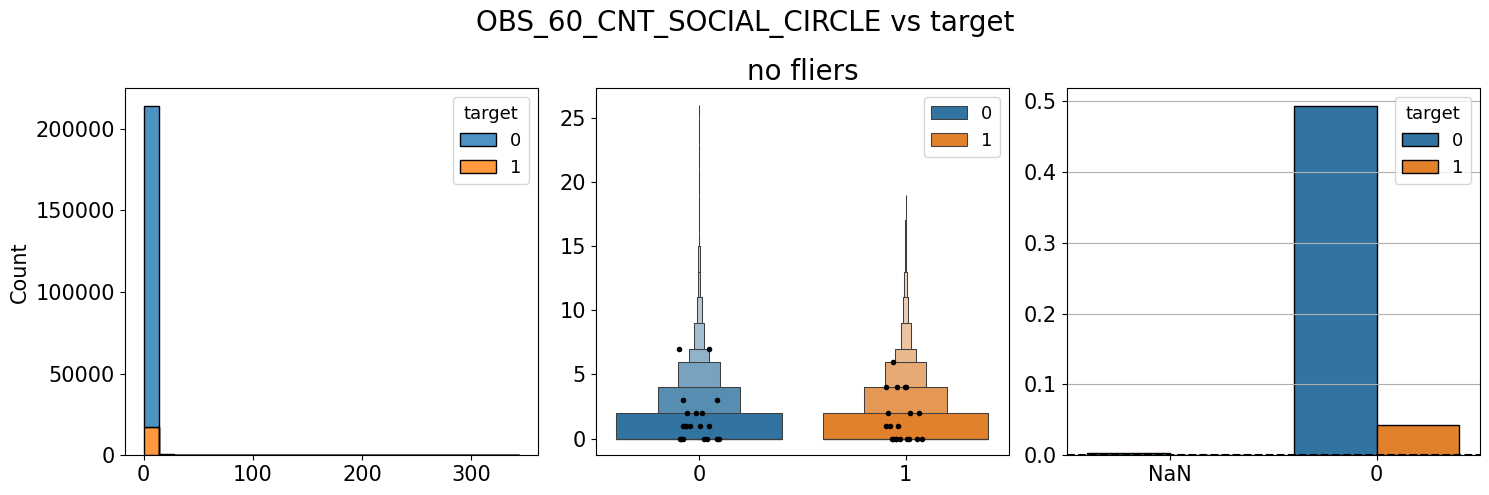

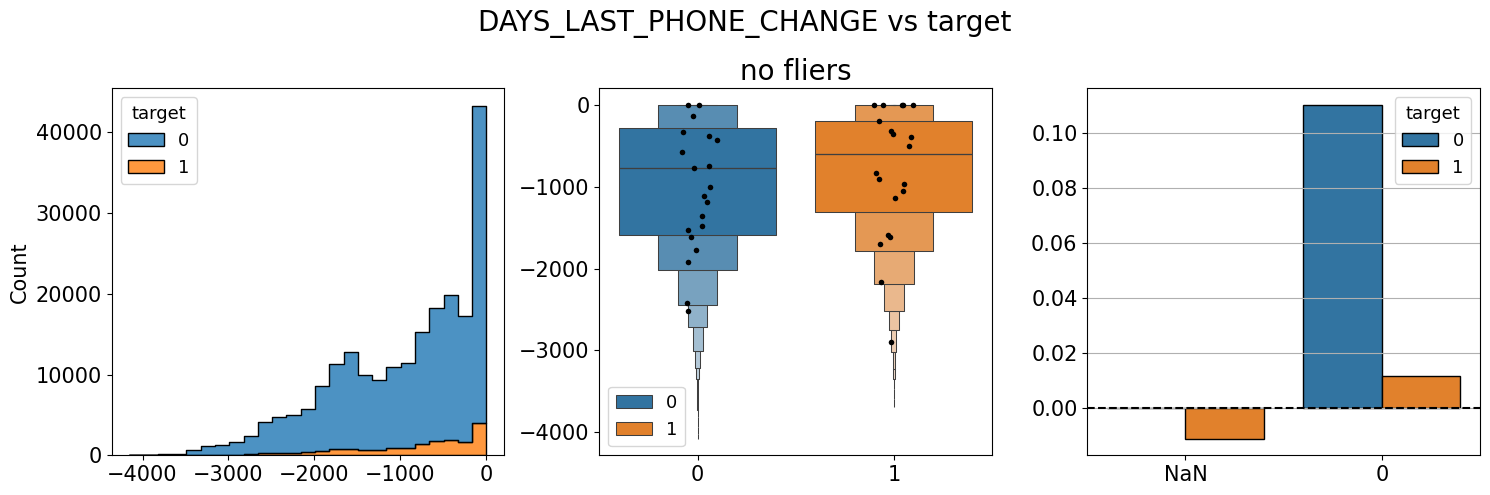

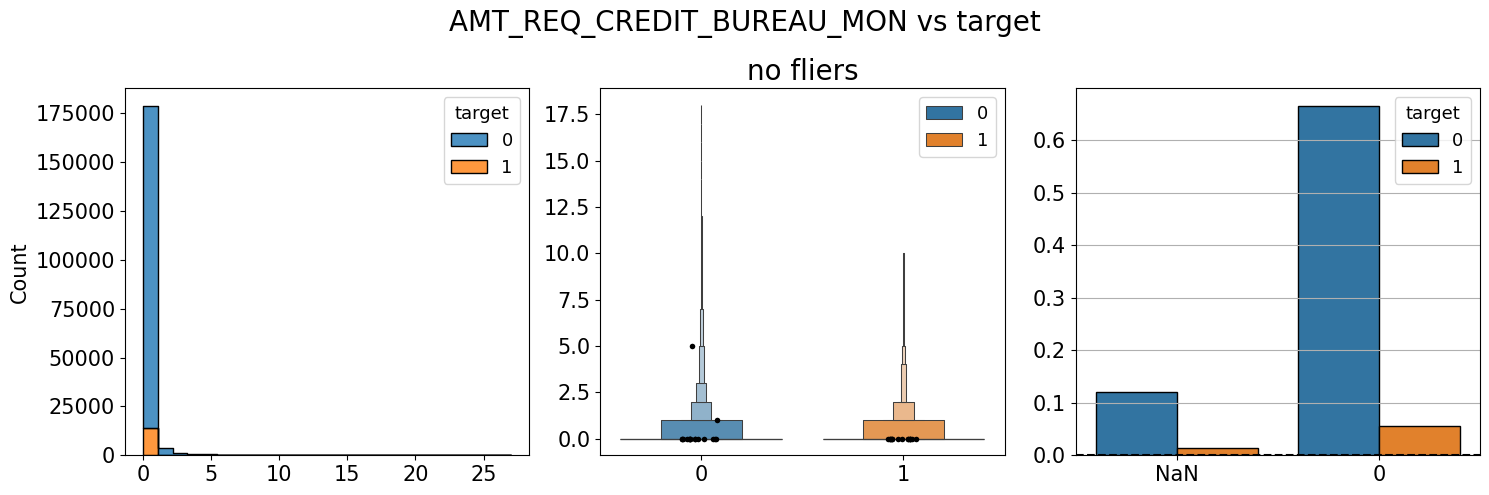

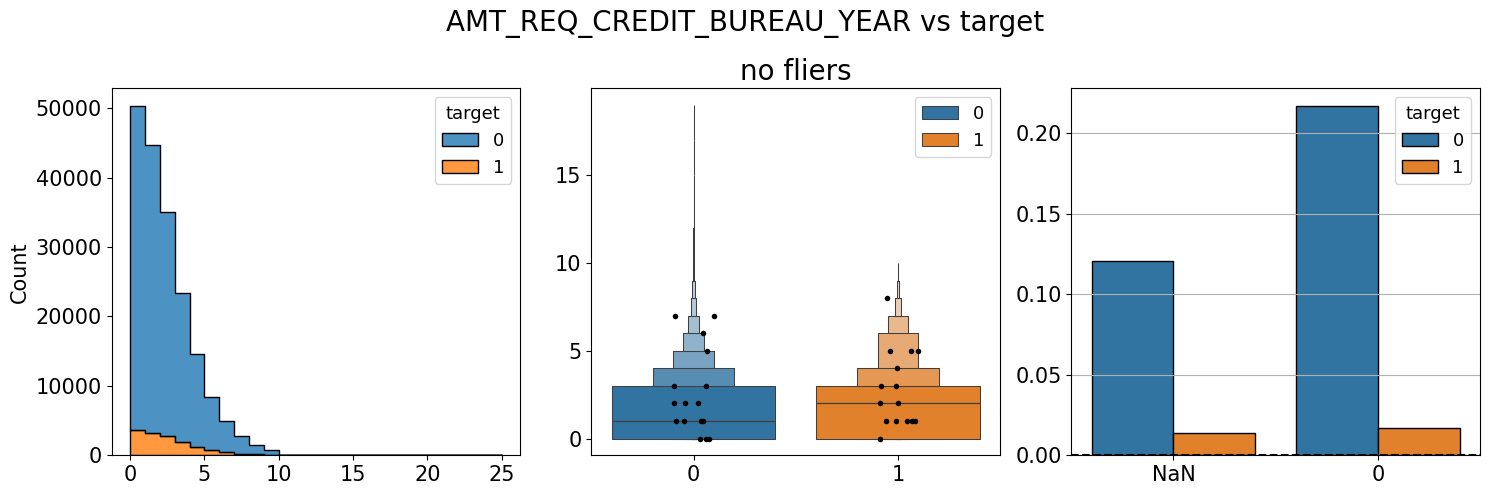

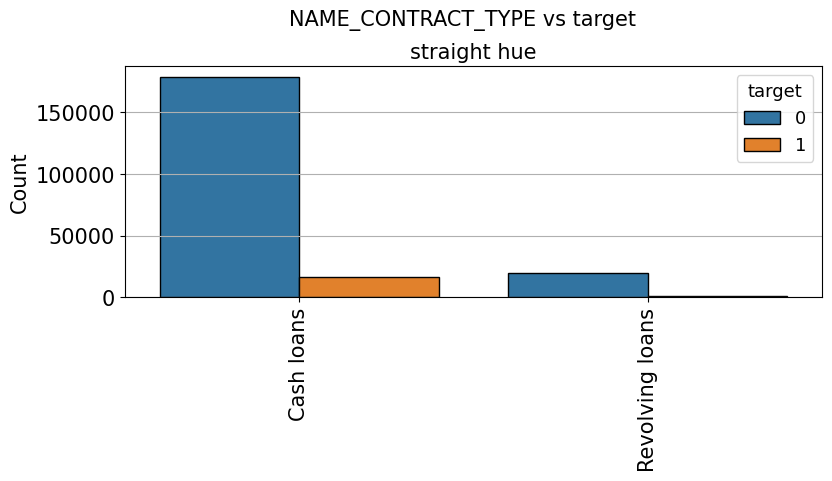

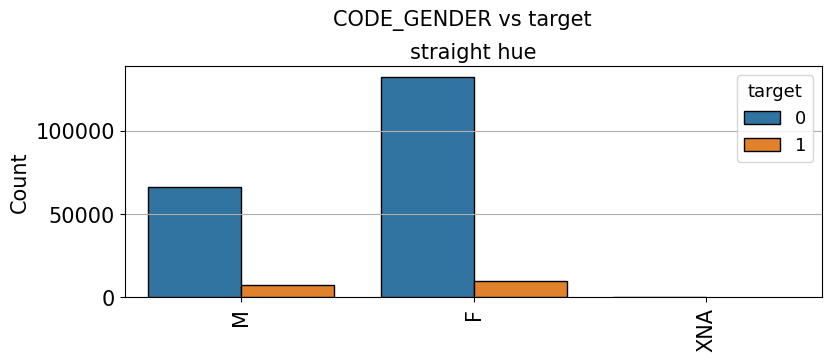

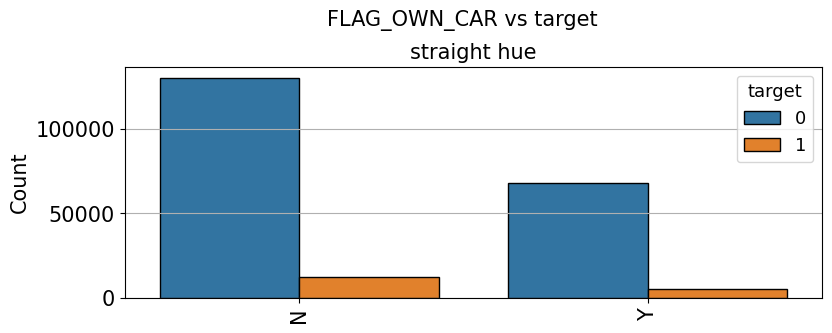

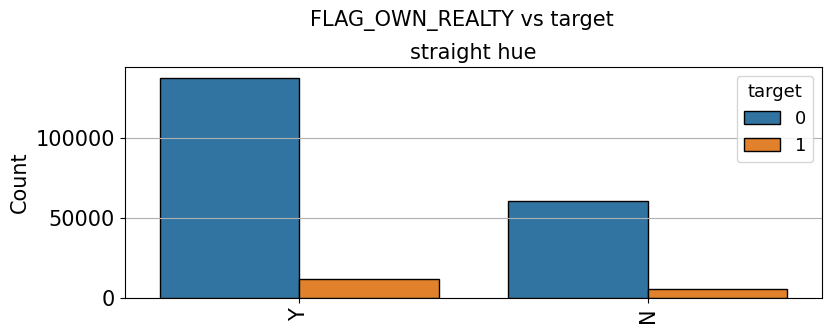

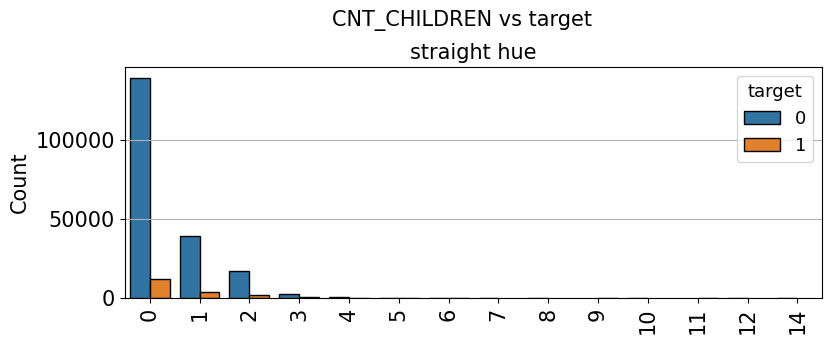

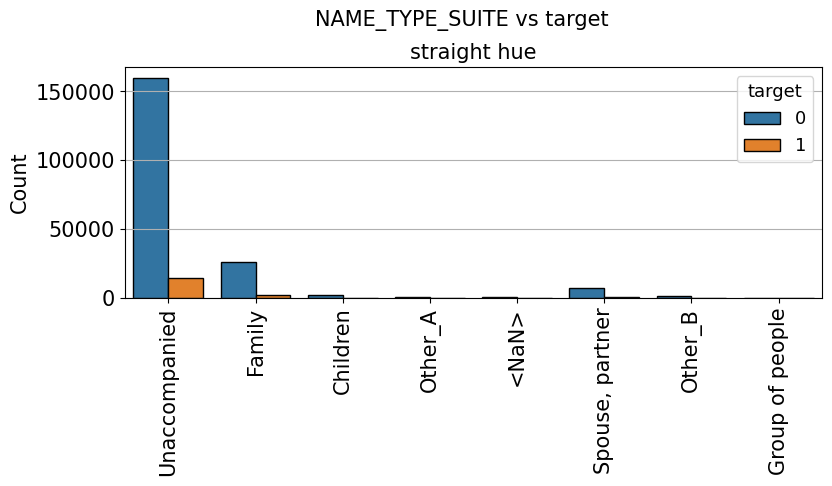

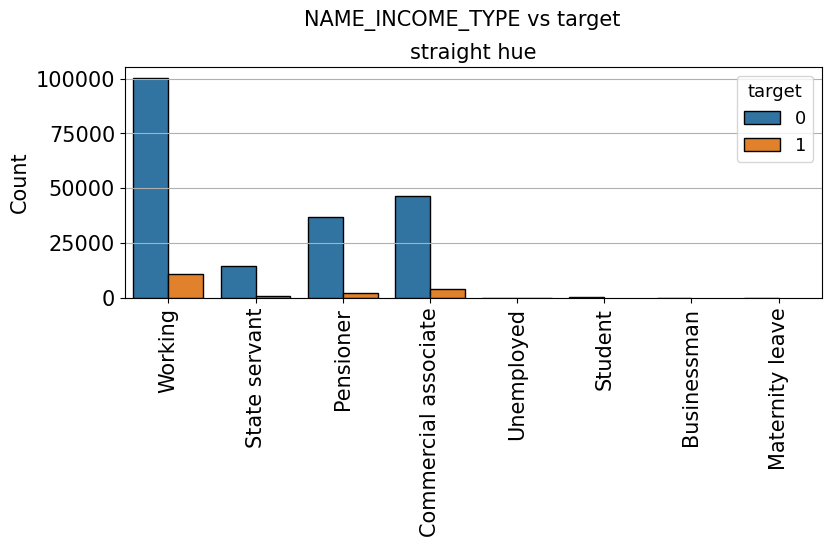

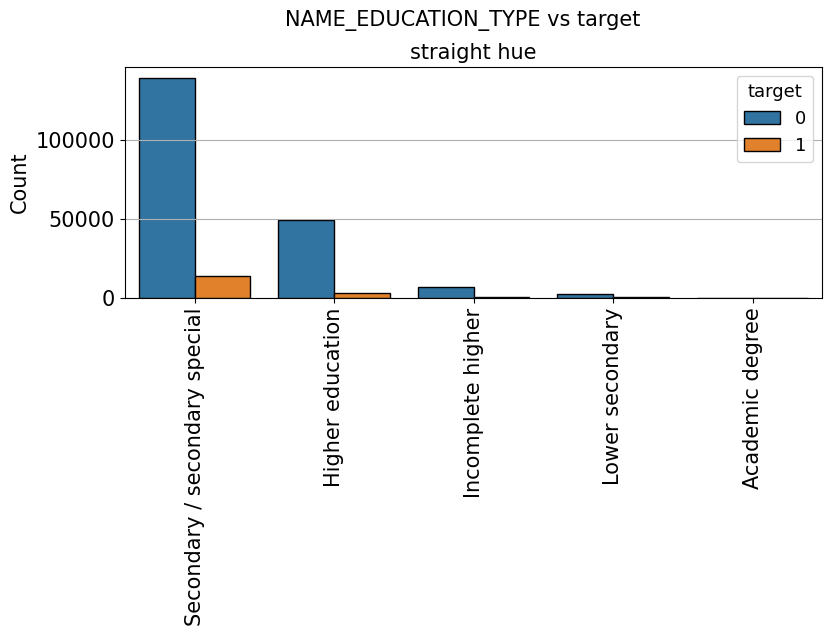

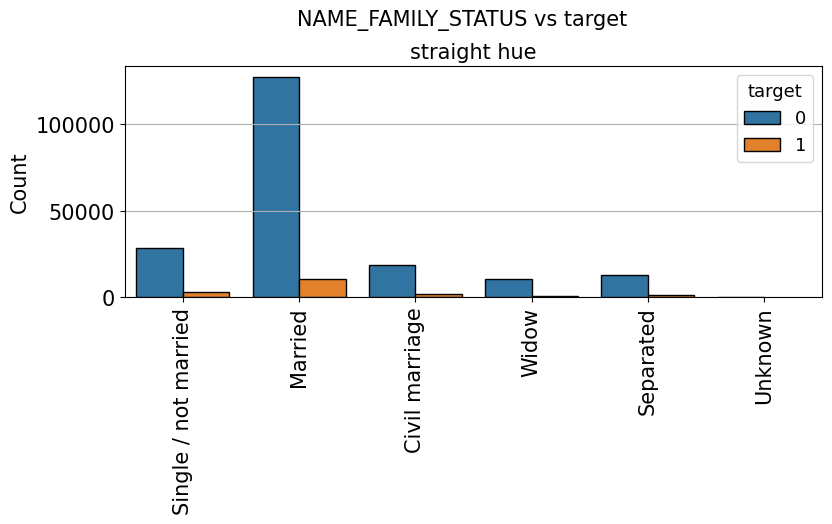

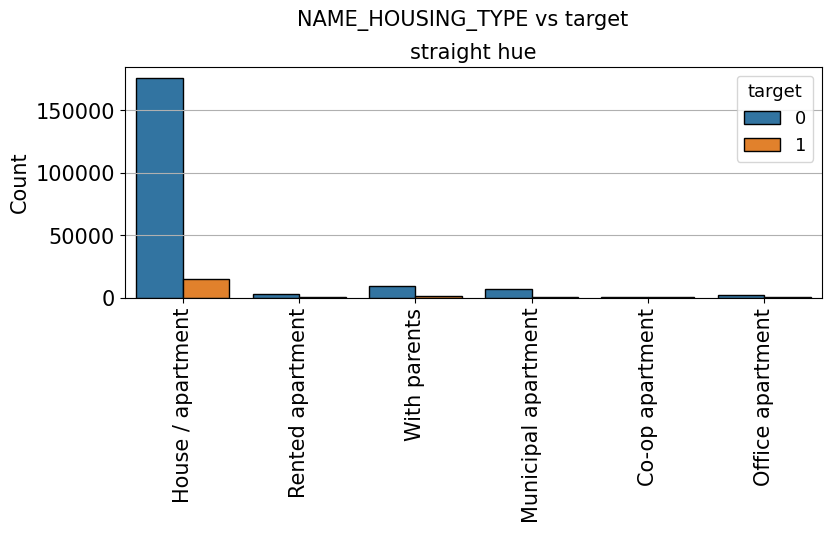

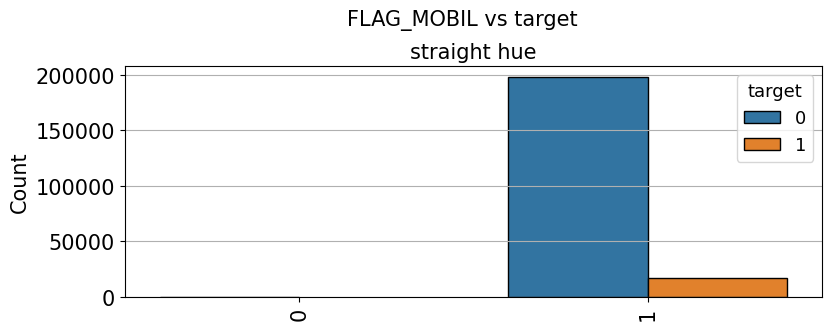

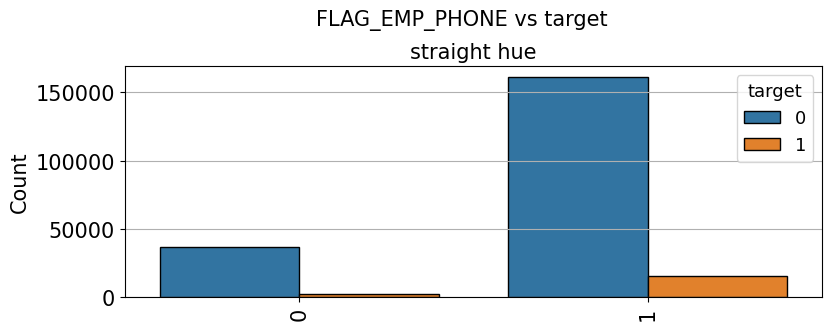

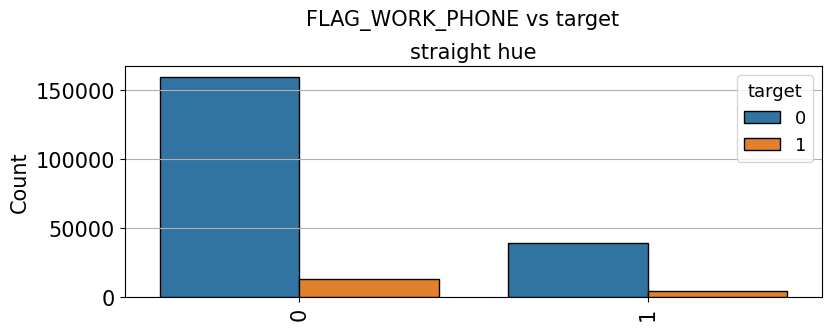

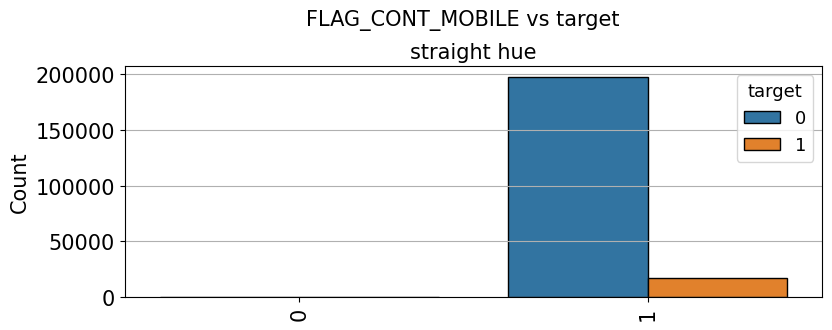

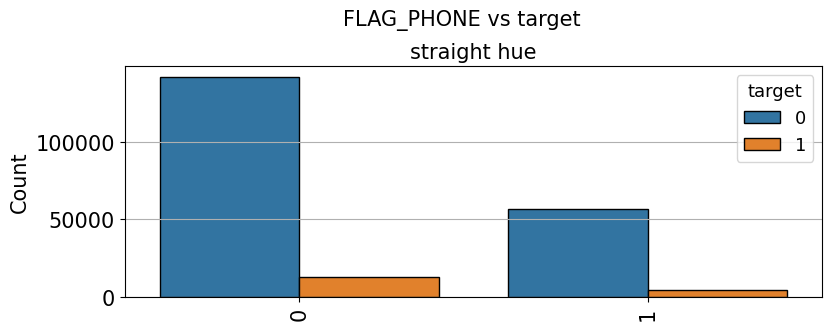

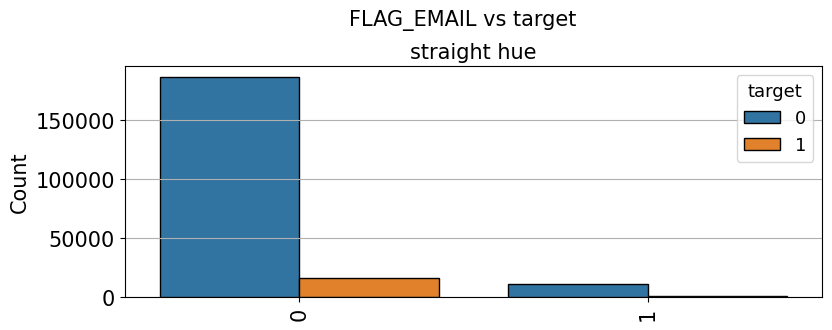

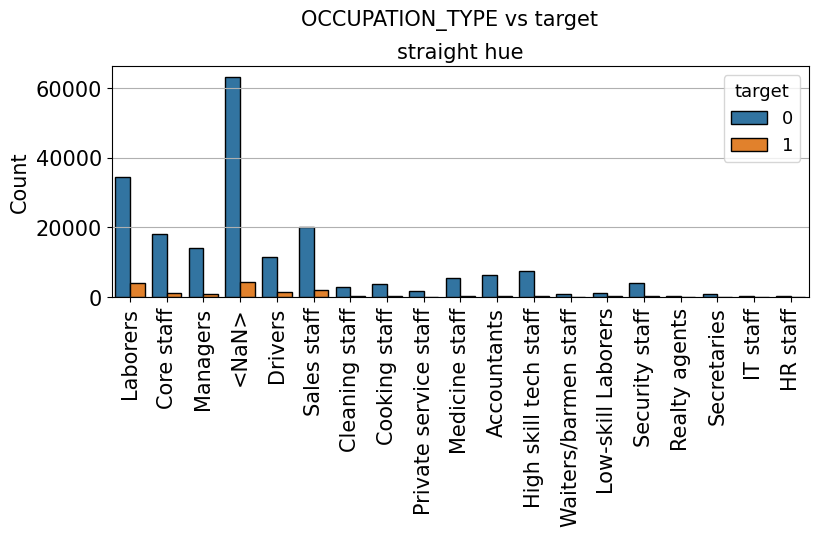

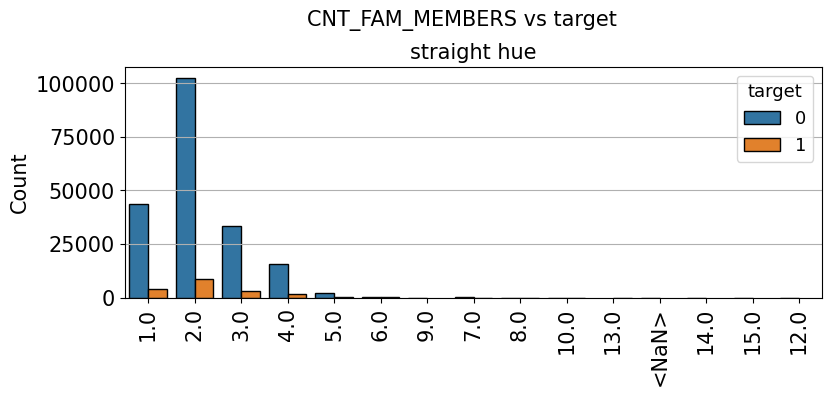

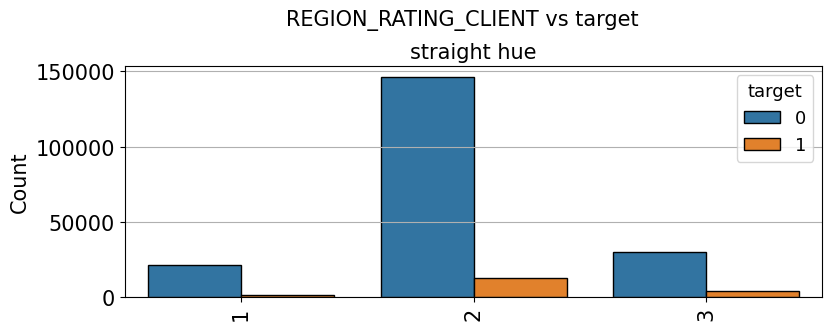

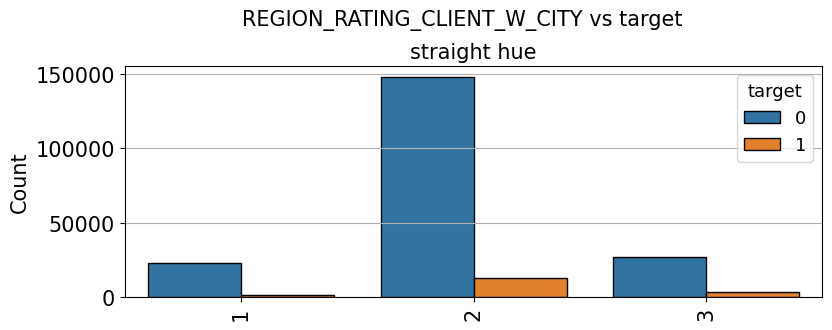

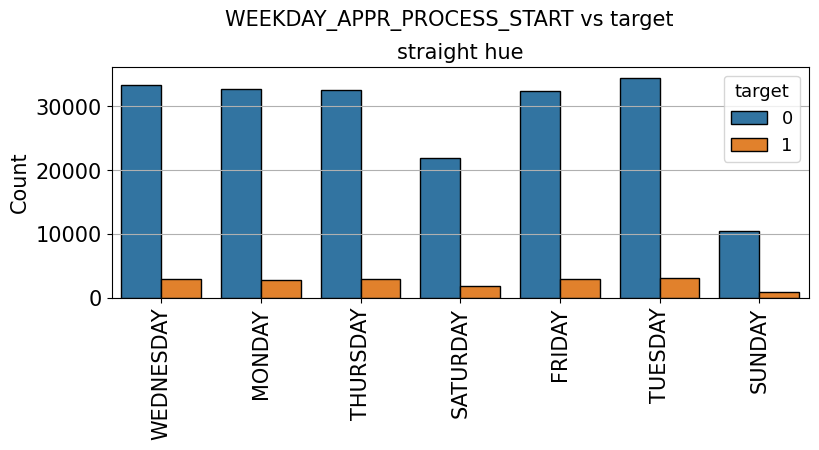

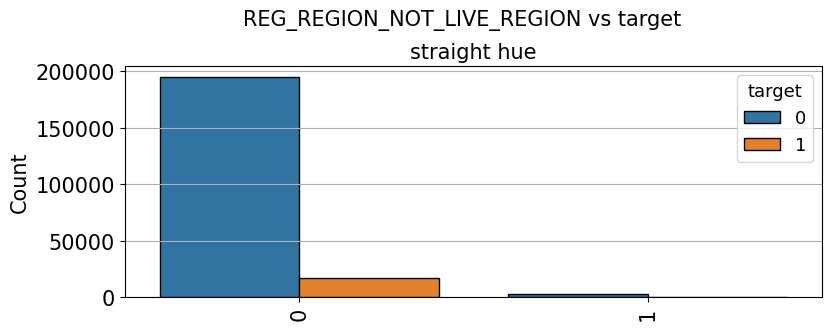

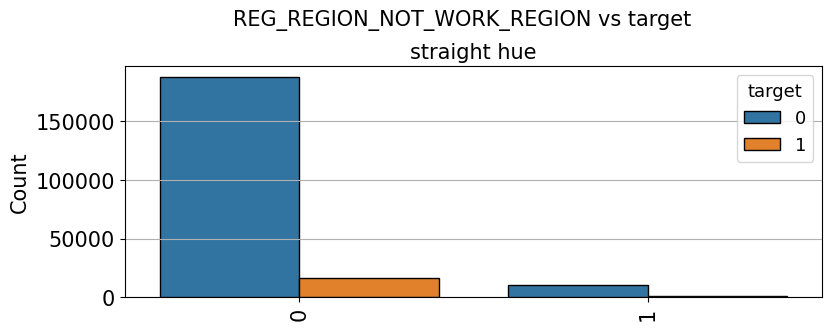

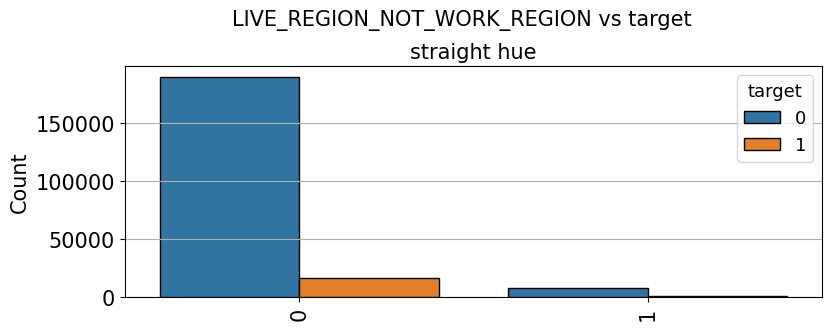

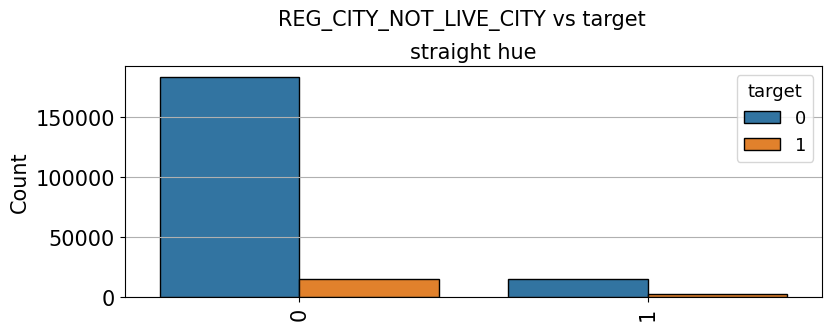

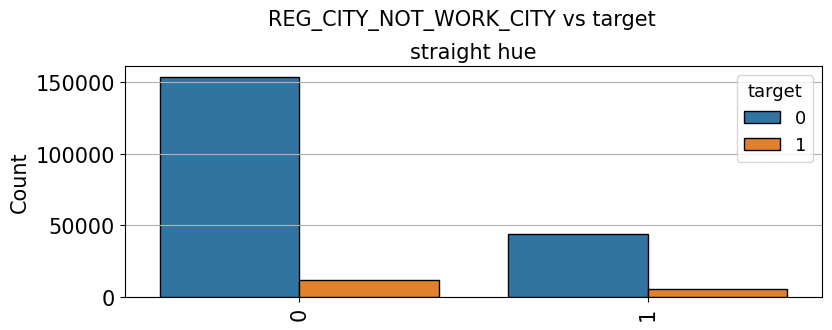

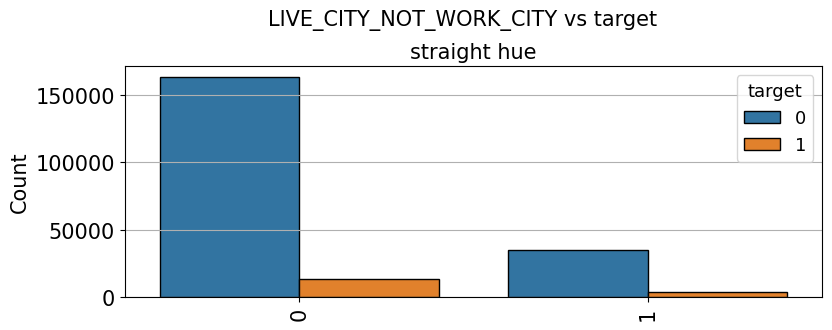

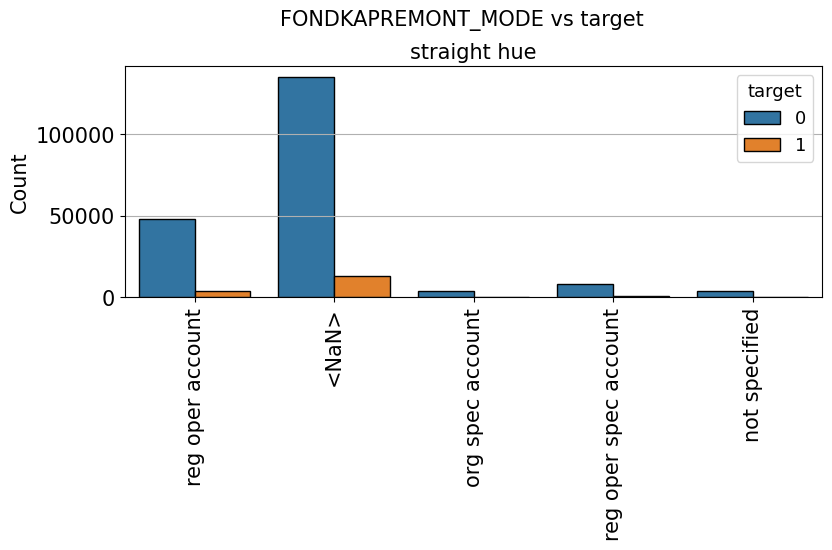

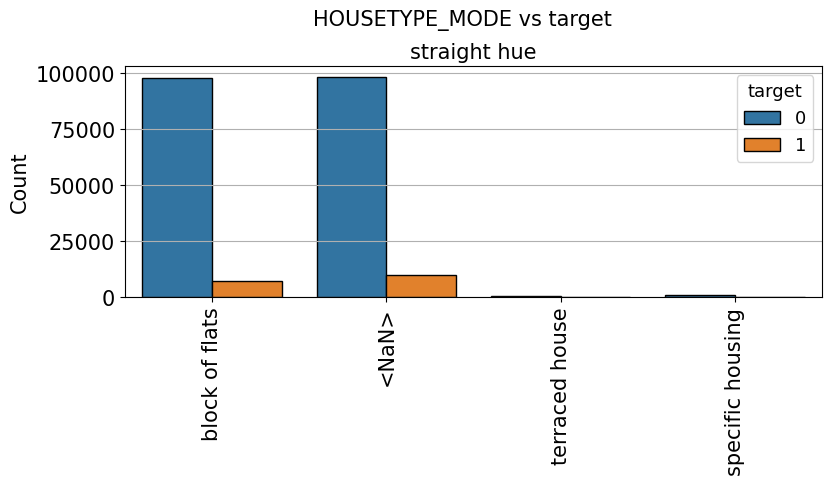

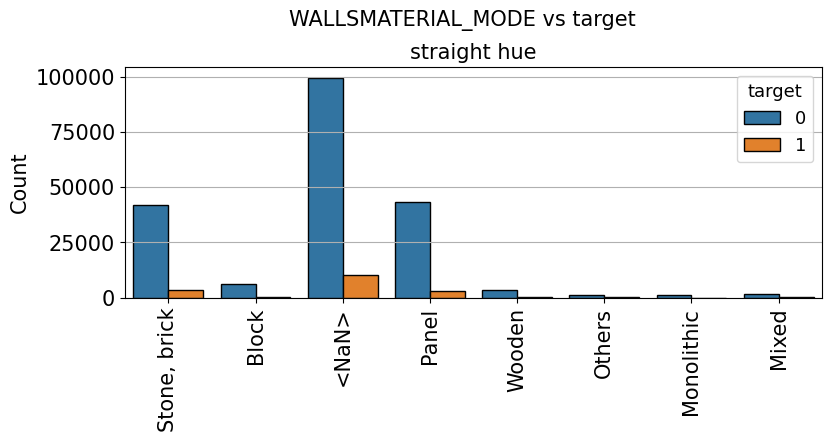

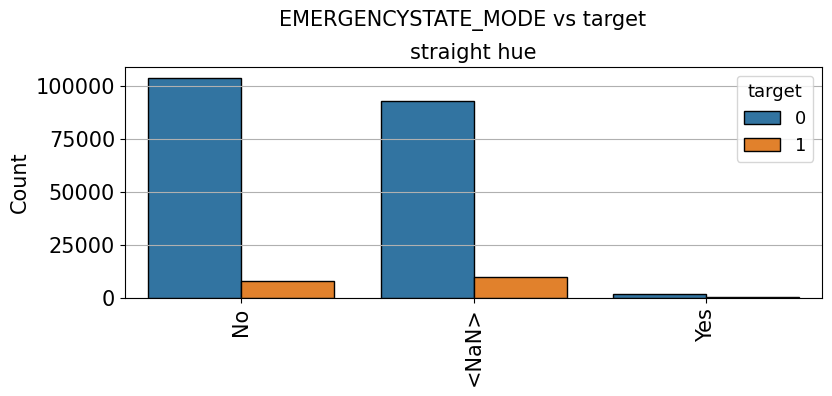

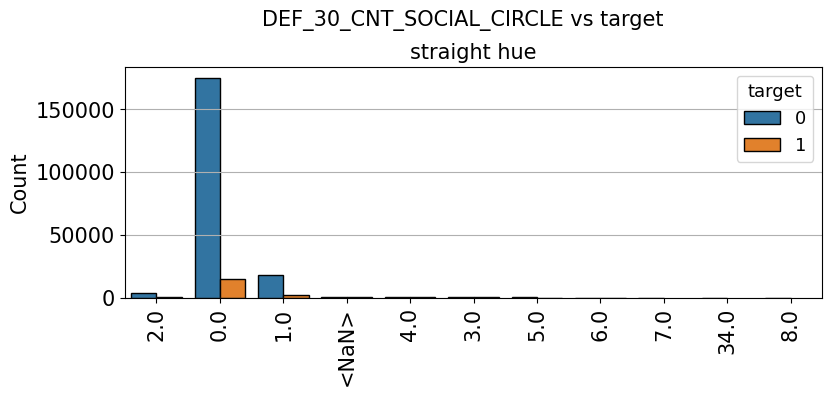

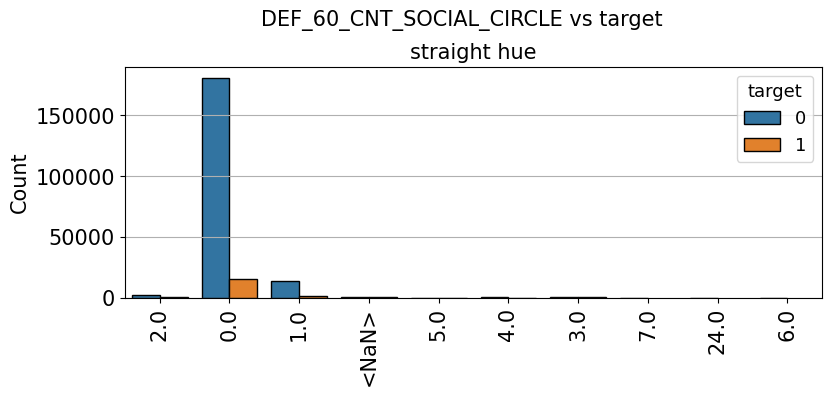

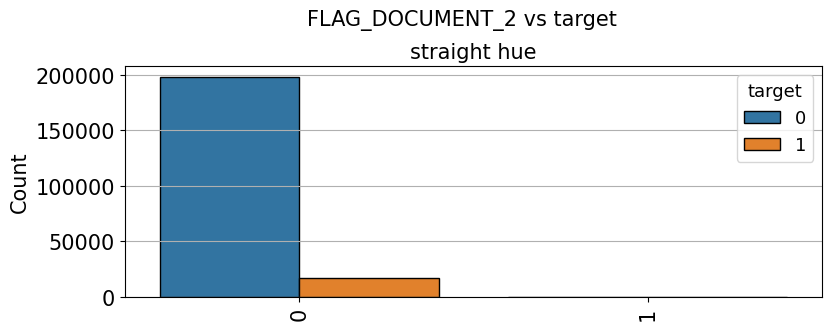

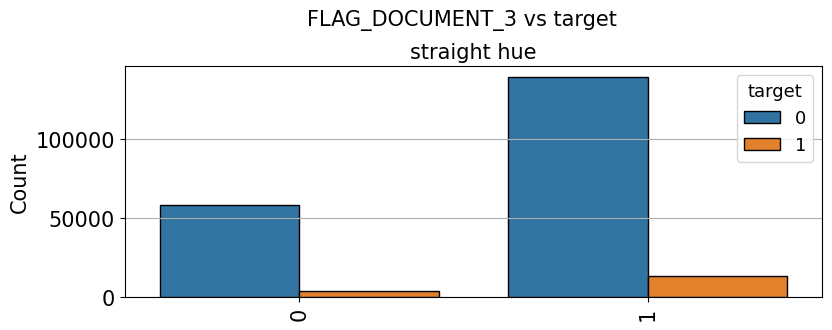

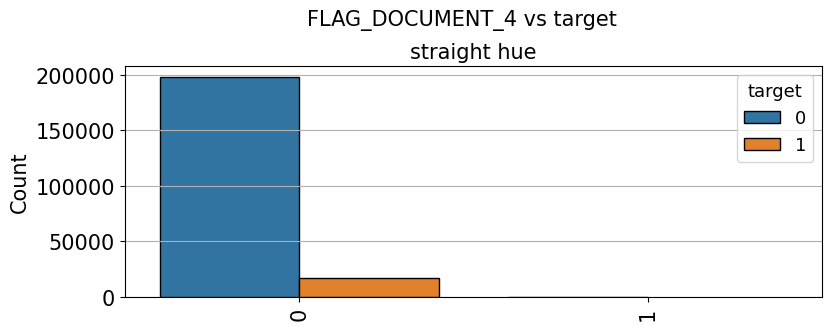

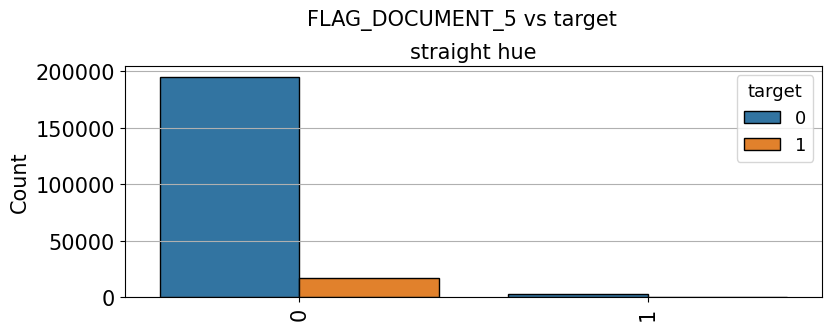

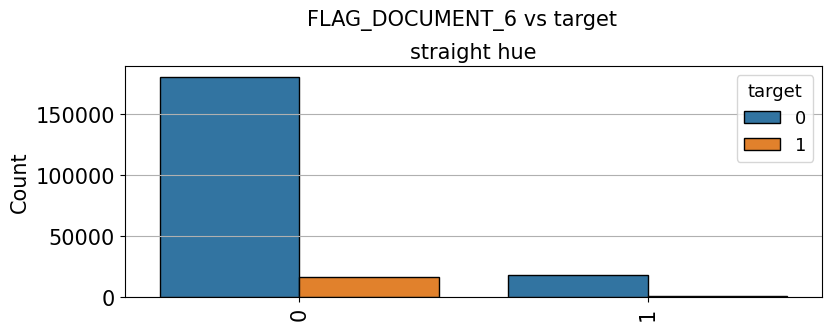

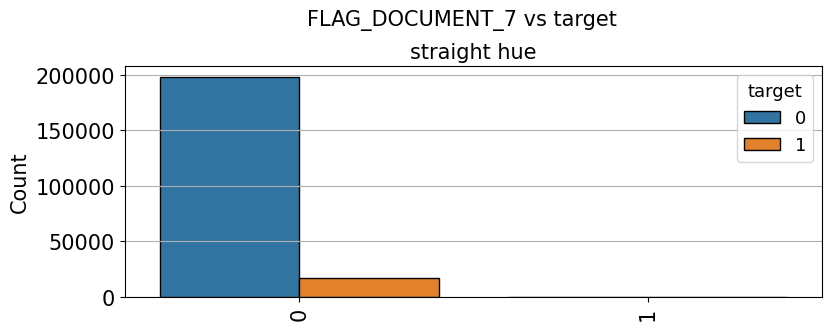

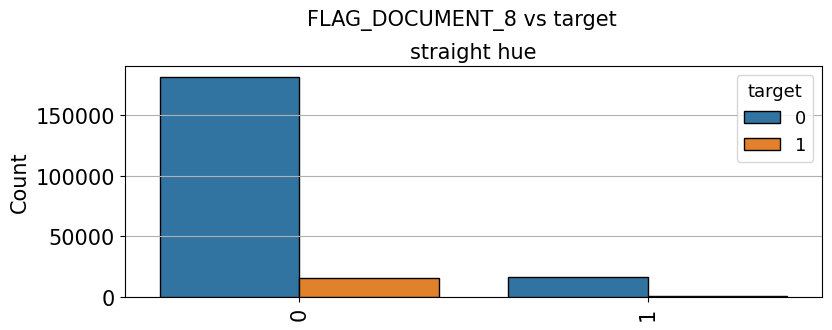

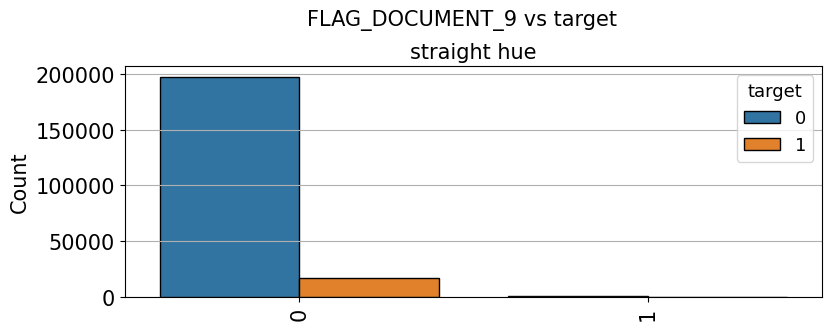

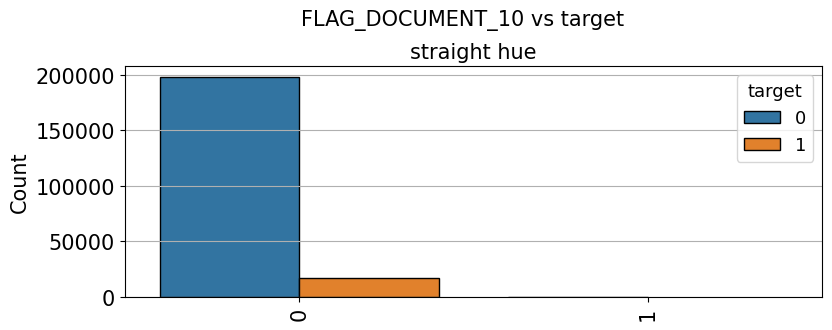

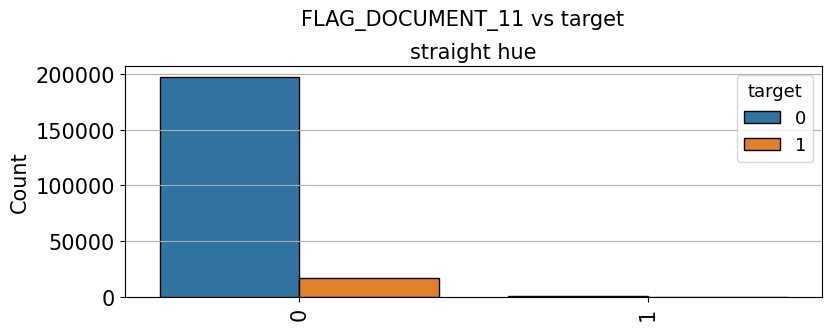

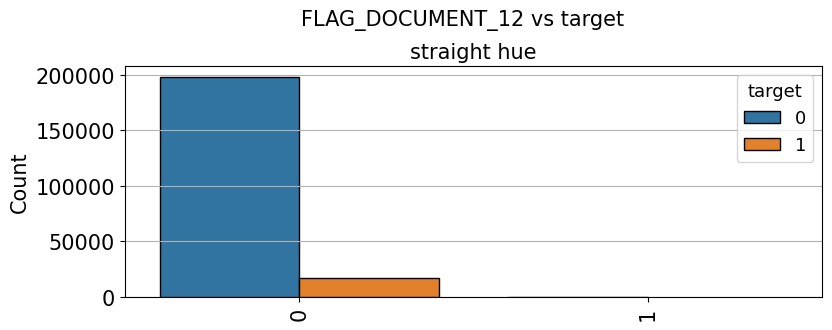

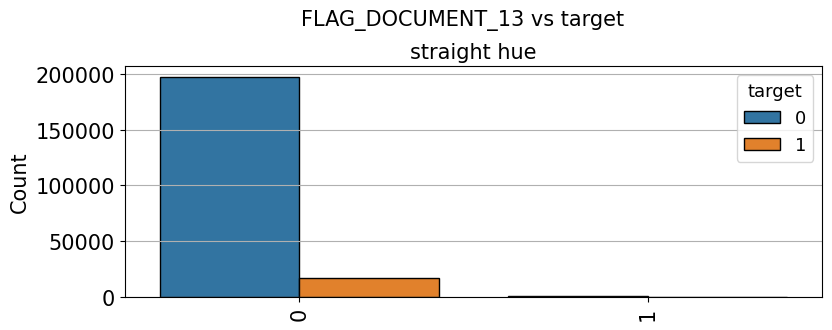

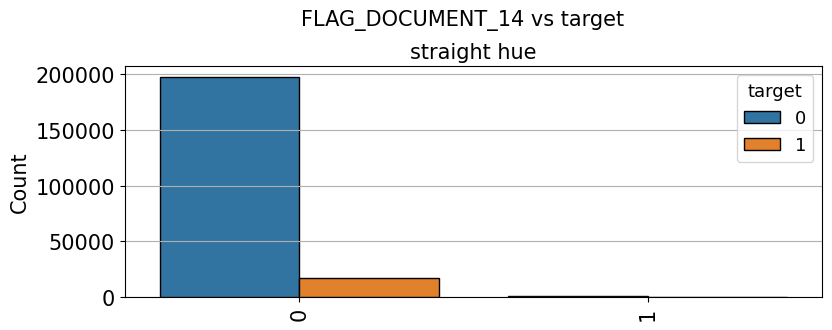

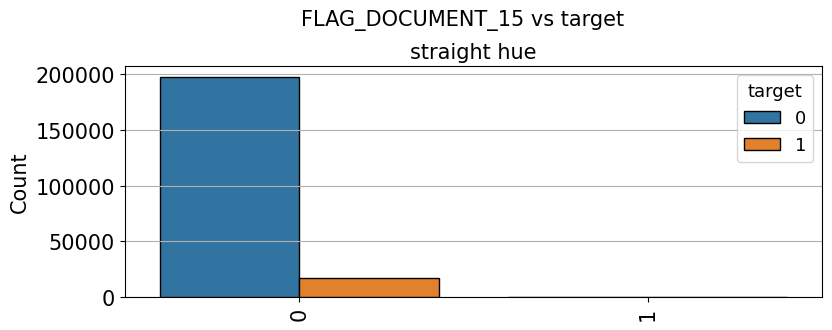

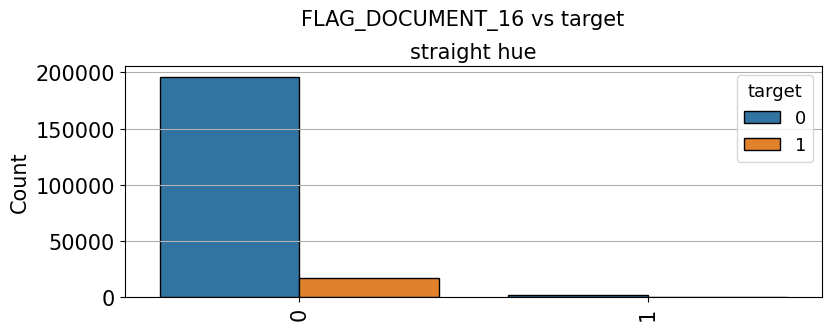

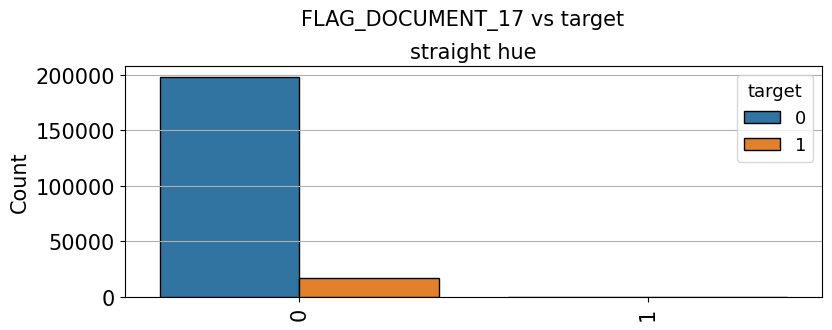

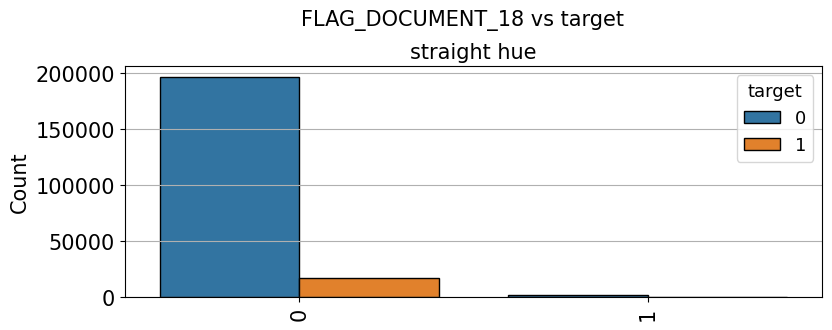

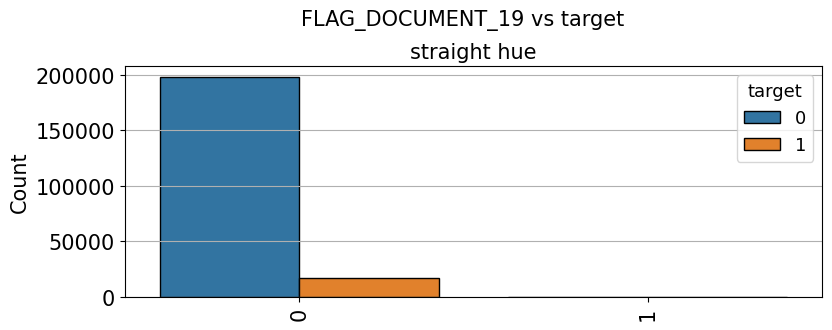

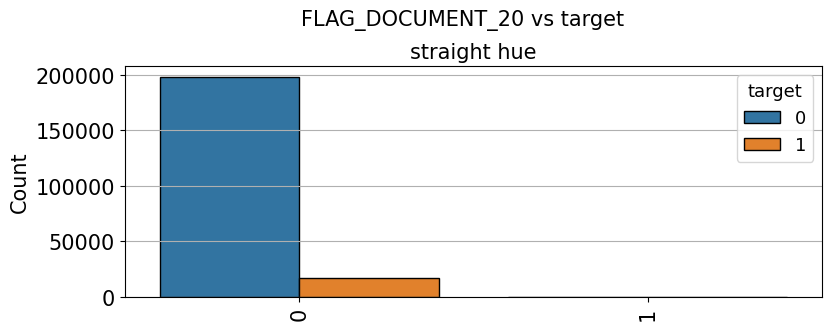

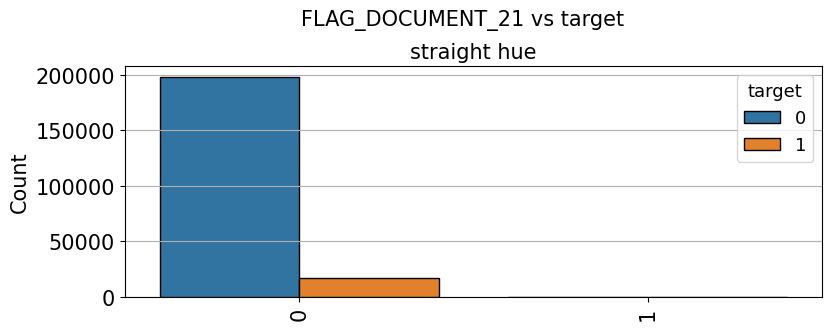

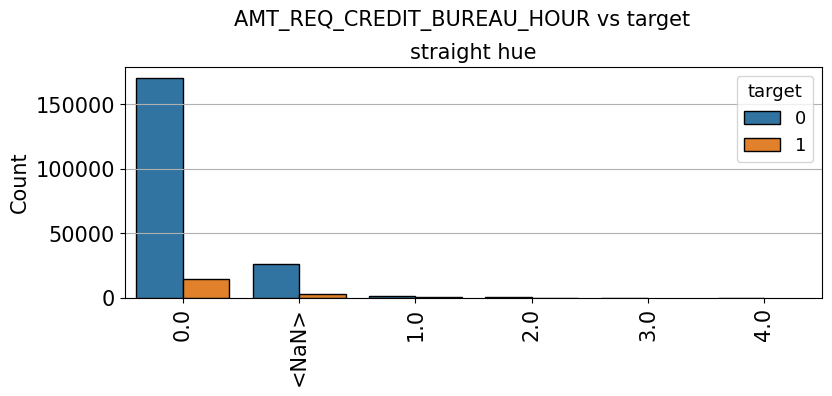

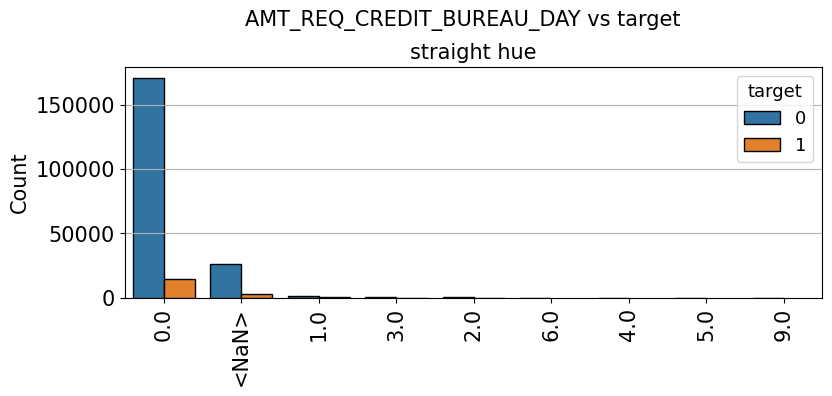

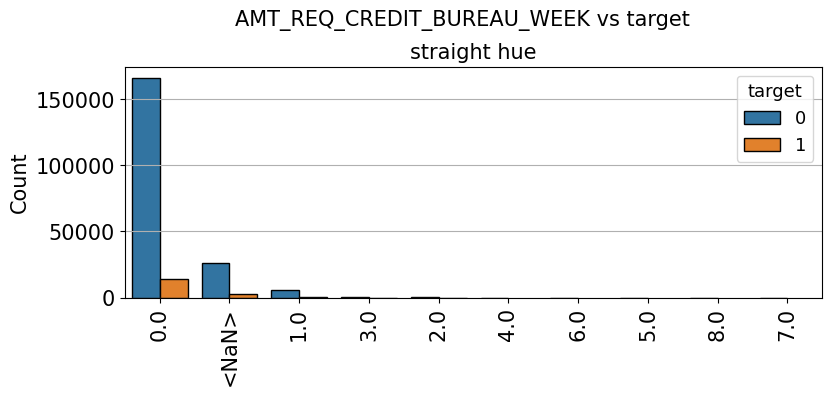

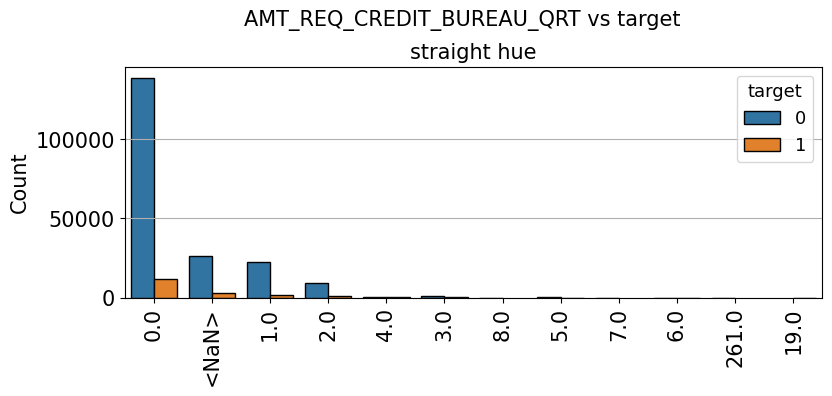

In [13]:
my_utils.plot_density(data_dict['tr'], hue="target")

Нетрудно заметить, что колонки, отвечающие за количество дней (чего бы то ни было), отсчитываются с настоящего момента, следовательно принимают отрицательные значения. При этом замечании тем более странно смотрится самое частое значение колонки ```"DAYS_EMPLOYED"```, равное 365243 (что в днях является огромным сроком), а также его большая доля - 0.18.

Можно убедиться, что кроме значения 365243, все остальные принимают отрицательные значения:

In [14]:
(data_dict['tr'].DAYS_EMPLOYED[data_dict['tr'].DAYS_EMPLOYED != 365243] > 0).sum()

0

Заменим данные выбросы средним значением по объектам, имеющим отрицательные значения.

In [15]:
mask_tr = data_dict["tr"].DAYS_EMPLOYED == 365243
data_dict["tr"].loc[mask_tr, "DAYS_EMPLOYED"] = int(
    data_dict["tr"].DAYS_EMPLOYED[~mask_tr].mean()
)
mask_tst = data_dict["tst"].DAYS_EMPLOYED == 365243
data_dict["tst"].loc[mask_tst, "DAYS_EMPLOYED"] = int(
    data_dict["tst"].DAYS_EMPLOYED[~mask_tst].mean()
)

Реализуем ниже трансформер на основе ```SimpleImputer```, заполняющий пропуски и добавляющий колонку-флаг, сигнализирующую о том, был ли пропуск.

In [16]:
class MissingIndicatorImputer(BaseEstimator, TransformerMixin):
    """
    Трансформер для обработки пропусков в данных.

    Этот класс выполняет замену пропущенных значений (NaN) с помощью указанного стратегией заполнителя
    (`imputer`) и, при необходимости, добавляет индикаторные признаки, указывающие на наличие пропусков.

    Атрибуты:
        imputer (SimpleImputer): Заполнитель для обработки пропусков. По умолчанию используется заполнение
            средним значением (`strategy="mean"`).
        add_indicator (bool): Если True, добавляет дополнительные признаки, указывающие на наличие пропусков
            в каждой колонке исходного набора данных.
    """

    def __init__(self, imputer=None, add_indicator=True):
        """
        :param imputer: Объект SimpleImputer или его конфигурация. По умолчанию используется заполнение медианой.
        :param add_indicator: Флаг для добавления индикаторных признаков пропусков.
        """
        if imputer is None:
            self.imputer = SimpleImputer(strategy="mean")
        else:
            self.imputer = imputer
        self.add_indicator = add_indicator

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        X_transformed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

        if self.add_indicator:
            missing_indicators = pd.DataFrame(
                {f"{col}_missing": X[col].isna().astype(int) for col in X.columns},
                index=X.index,
            )
            X_transformed = pd.concat([X_transformed, missing_indicators], axis=1)

        return X_transformed

Из описания ```description.csv``` можем узнать, что ```"AMT_INCOME_TOTAL"``` -- общий доход клиента, ```"AMT_CREDIT"``` -- сумма кредита, ```"AMT_ANNUITY"``` -- аннуитет по кредиту, ```"DAYS_EMPLOYED"``` -- сколько дней клиент работает на должности к настояющему моменту, ```"DAYS_BIRTH"``` -- возраст в днях.

 На основе данных колонок можем сгенерировать 4 полезных признака:
 1. Продолжительность выплат по времени, необходимых, чтобы закрыть кредит.
 2. Доля кредита от дохода.
 3. Доля аннуитета от дохода.
 4. Доля продолжительности занятия должности от возраста.

In [17]:
for i in ["tr", "tst"]:
    data_dict[i]["duration_payment"] = (
        data_dict[i]["AMT_CREDIT"] / data_dict[i]["AMT_ANNUITY"]
    )
    data_dict[i]["amt_credit_vs_income"] = (
        data_dict[i]["AMT_CREDIT"] / data_dict[i]["AMT_INCOME_TOTAL"]
    )
    data_dict[i]["amt_annuity_vs_income"] = (
        data_dict[i]["AMT_ANNUITY"] / data_dict[i]["AMT_INCOME_TOTAL"]
    )
    data_dict[i]["days_employed_vs_days_birth"] = (
        data_dict[i]["DAYS_EMPLOYED"] / data_dict[i]["DAYS_BIRTH"]
    )

In [18]:
num_list = list(num_features)
num_list.append("duration_payment")
num_list.append("amt_credit_vs_income")
num_list.append("amt_annuity_vs_income")
num_list.append("days_employed_vs_days_birth")

Воспользуемся ```sklearn.preprocessing.PolynomialFeatures``` для генерации признаков. Выделим 4 группы так, что внутри каждой параметры более или менее связаны друг с другом. Делаем это в надежде получить более сложные нелинейные зависимости.

In [19]:
len(num_features)

104

In [20]:
credit_columns = ["amt_credit_vs_income", "AMT_CREDIT", "AMT_INCOME_TOTAL"]
client_columns = ["duration_payment", "DAYS_EMPLOYED", "DAYS_BIRTH"]
apartment_columns = [
    "LIVINGAREA_MEDI",
    "APARTMENTS_MEDI",
    "ELEVATORS_AVG",
    "COMMONAREA_MEDI",
]
ext_source_columns = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

Также применим дискретизацию в двум колонкам датасета. Поделим (квантильно) доходы клиентов на 50 бинов, возраст -- на 12 бинов. Такая бинаризация поможет модели легче нащупать зависимости для предсказания таргета. Данный процесс помогает более адекватно обрабатывать выбросы (либо валидные, но аномально большие значения), что применительно к колонке доходов.

Для численных колонок завершающим этапом будет ```StandardScaler()```.

Для категориальных колонок ограничимся ```SimpleImputer``` и ```SumEncoder```. ```SumEncoder``` сравнивает среднее значение зависимой переменной (таргета) для данного значения категориального столбца с общим средним значением целевой величины.

Получившийся пайплайн представлен ниже. В качестве первых пристрелочных параметров логистической регрессии возьмем ```C=0.05, solver='newton-cholesky'``` (по опыту с предыдущего семинара).

In [21]:
num_transformer = Pipeline(
    [
        (
            "imputer_with_indicator",
            MissingIndicatorImputer(
                imputer=SimpleImputer(strategy="mean"), add_indicator=True
            ),
        ),
        (
            "poly_features_and_binarize",
            ColumnTransformer(
                transformers=[
                    (
                        "poly_credit",
                        PolynomialFeatures(degree=4, include_bias=False),
                        credit_columns,
                    ),
                    (
                        "poly_client",
                        PolynomialFeatures(degree=5, include_bias=False),
                        client_columns,
                    ),
                    (
                        "poly_apartment",
                        PolynomialFeatures(degree=3, include_bias=False),
                        apartment_columns,
                    ),
                    (
                        "poly_ext",
                        PolynomialFeatures(degree=4, include_bias=False),
                        ext_source_columns,
                    ),
                    (
                        "binarize_amt_income",
                        KBinsDiscretizer(
                            n_bins=50,
                            encode="ordinal",
                            strategy="quantile",
                            subsample=None,
                            random_state=42,
                        ),
                        ["AMT_INCOME_TOTAL"],
                    ),
                    (
                        "binarize_days_birth",
                        KBinsDiscretizer(
                            n_bins=12,
                            encode="ordinal",
                            strategy="quantile",
                            subsample=None,
                            random_state=42,
                        ),
                        ["DAYS_BIRTH"],
                    ),
                ],
                remainder="passthrough",
            ),
        ),
        ("scaler", StandardScaler()),
    ]
)
cat_transformer = Pipeline(
    steps=[
        ("imp_most_freq", SimpleImputer(strategy="most_frequent")),
        ("se", SumEncoder(handle_unknown="ignore")),
    ]
)


ct = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_list),
        ("cat", cat_transformer, list(cat_features)),
    ]
)

pipeline = Pipeline(
    [
        ("ct", ct),
        (
            "model",
            LogisticRegression(
                C=0.05,
                solver="newton-cholesky",
                random_state=0,
                n_jobs=-1,
                max_iter=2000,
            ),
        ),
    ]
)

pipeline.fit(data_dict["tr"], data_dict["tr"].target)
roc_auc_score(data_dict["tst"].target, pipeline.predict_proba(data_dict["tst"])[:, 1])

0.7560807881778064

Выбейте на тесте больше `0.752` [roc_auc_score](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html).
Для поиска лучшей модели можно использовать:
- optuna
- [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)
- свои наблюдения и интуицию

Постараемся улучшить ```ROC_AUC_SCORE``` с помощью optuna.

In [22]:
import optuna

In [23]:
def my_objective(trial: optuna.trial.Trial, X_tr, X_val, y_tr, y_val):
    solver = trial.suggest_categorical(
        "solver", ["liblinear", "lbfgs", "saga", "sag", "newton-cg", "newton-cholesky"]
    )
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    C = trial.suggest_float("C", 1e-4, 1e2, log=True, step=None)
    l1_ratio = None

    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    if penalty == "elasticnet" and solver != "saga":
        raise optuna.exceptions.TrialPruned()
    if penalty == "None" and solver not in [
        "lbfgs",
        "sag",
        "saga",
        "newton-cg",
        "newton-cholesky",
    ]:
        raise optuna.exceptions.TrialPruned()
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    pipeline = Pipeline(
        [
            ("ct", ct),
            (
                "model",
                LogisticRegression(
                    solver=solver,
                    penalty=penalty,
                    C=C,
                    l1_ratio=l1_ratio,
                    random_state=0,
                ),
            ),
        ]
    )
    pipeline.fit(X_tr, y_tr)

    y_pred = pipeline.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)

    return score

In [24]:
study = optuna.create_study(sampler=None, direction="maximize")

from functools import partial

obj_func = partial(
    my_objective,
    X_tr=data_dict["tr"],
    X_val=data_dict["tst"],
    y_tr=data_dict["tr"].target,
    y_val=data_dict["tst"].target,
)

study.optimize(obj_func, n_trials=50, n_jobs=4, gc_after_trial=True)

[I 2024-11-25 11:12:15,524] A new study created in memory with name: no-name-d6f18a7f-96c2-44f6-82d8-859cf8bb94a8
[I 2024-11-25 11:12:15,555] Trial 2 pruned. 
[I 2024-11-25 11:12:58,161] Trial 3 finished with value: 0.7560809886588504 and parameters: {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 0.10863722480022206}. Best is trial 3 with value: 0.7560809886588504.
[I 2024-11-25 11:13:02,581] Trial 1 finished with value: 0.7551791901939197 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 7.755937314382237}. Best is trial 3 with value: 0.7560809886588504.
[I 2024-11-25 11:13:30,173] Trial 6 finished with value: 0.7544143629039978 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.004201382328310609}. Best is trial 3 with value: 0.7560809886588504.
[I 2024-11-25 11:13:32,566] Trial 0 finished with value: 0.7487717623554533 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.0006225308403964632}. Best is trial 3 with value: 0.7560809886588504.
[I 2024-11

In [25]:
study.best_trial.params

{'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 0.0760195853432445}

In [26]:
pipeline = Pipeline(
    [
        ("ct", ct),
        ("model", LogisticRegression(**study.best_trial.params, random_state=0)),
    ]
)
pipeline.fit(data_dict["tr"], data_dict["tr"].target)

y_pred = pipeline.predict_proba(data_dict["tst"])[:, 1]
score = roc_auc_score(data_dict["tst"].target, y_pred)

In [27]:
score

0.7561027732132383

Таким образом, в ходе данной работы было получено значение метрики ```ROC_AUC_SCORE```, равное 0.7561.

### Бонусы (до +5 баллов)

За вашу работу можно получить до 5 бонусных баллов <br>
За какие заслуги можно получить бонус:
- скор на тесте значительно больше 0.752 (будет сравниваться с другими работами студентов)
- интересные реализации кастомных трансформеров
- интересные находки в данных, которые увеличили вам скор. Опишите, что вы нашли и как это помогло увеличить скор.
- см. пункт "Хорошие работы" в [уставе](https://t.me/c/2206639786/270/271) 